## Includes and imports

---

In [3]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import cv2
import pytesseract
import skimage as ski
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.filters import threshold_otsu
import joblib  # For saving/loading models
from joblib import dump,load
import re
# Excel sheets
import openpyxl
from openpyxl.styles import PatternFill

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Aligning, thresholding and extracting cells

---

Processing Image 8


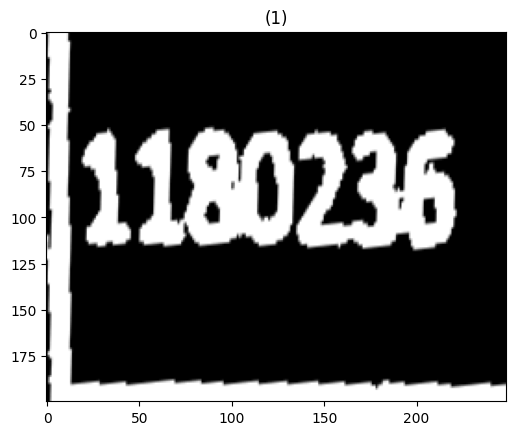

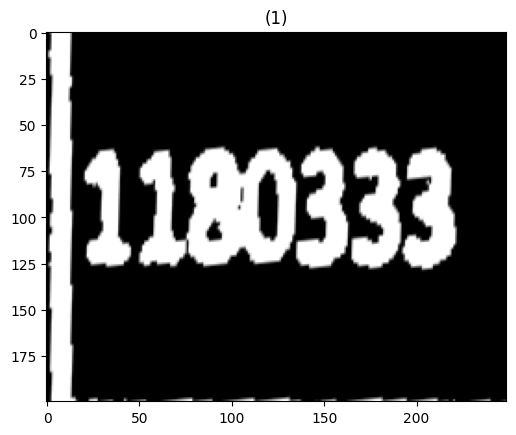

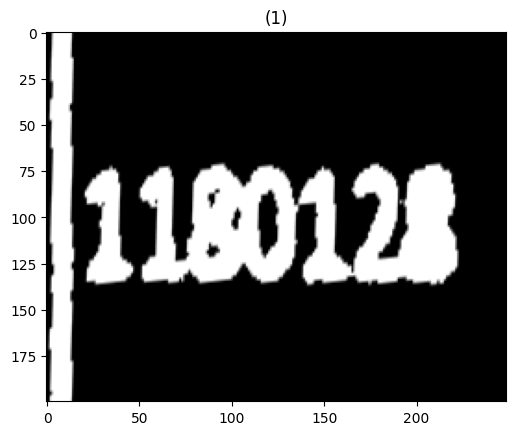

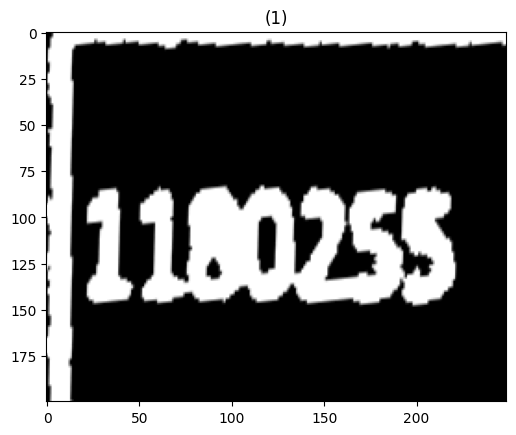

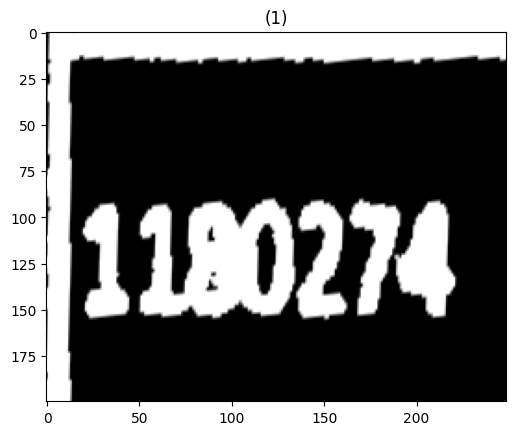

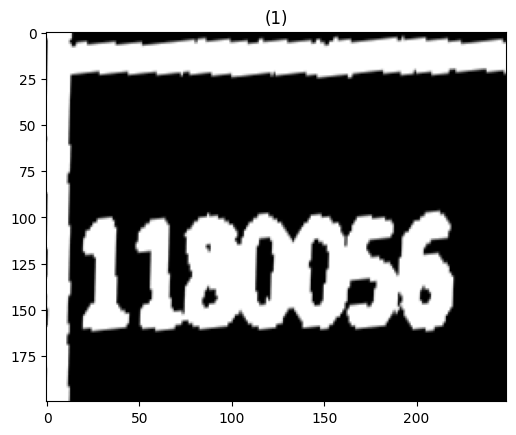

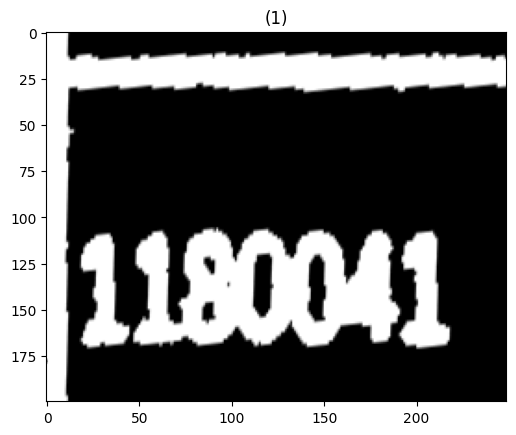

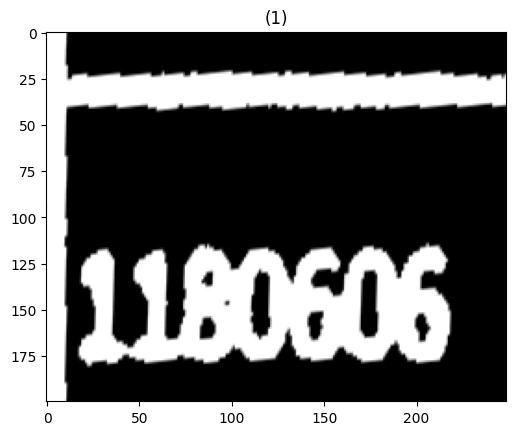

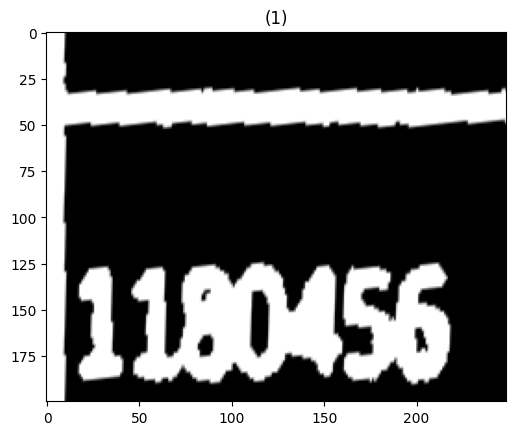

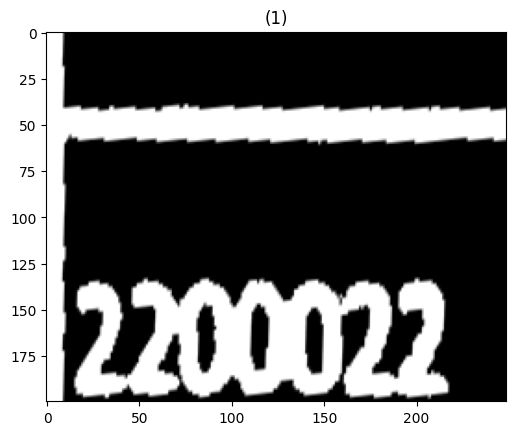

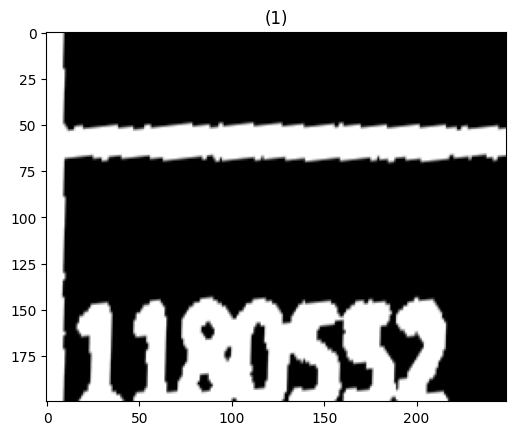

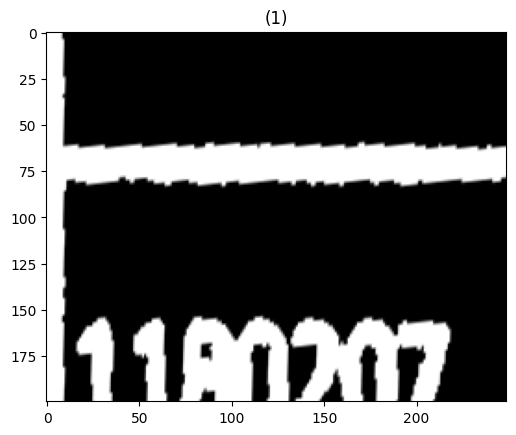

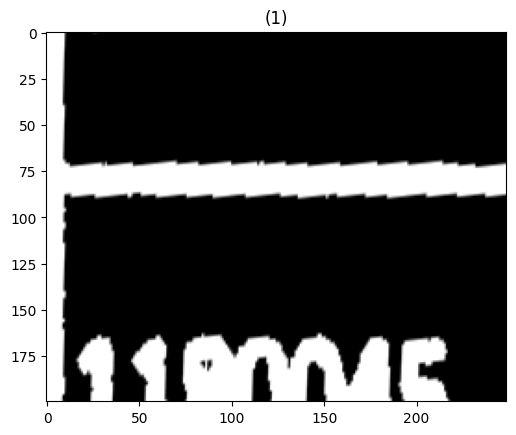

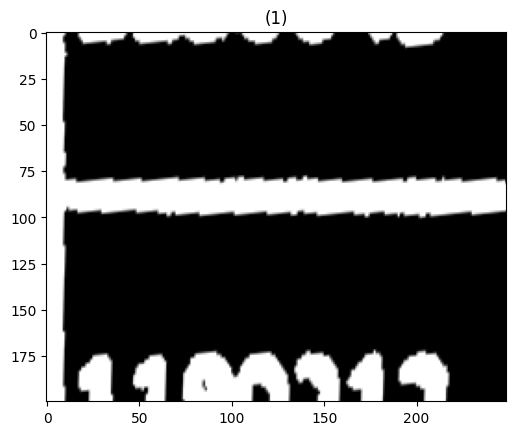

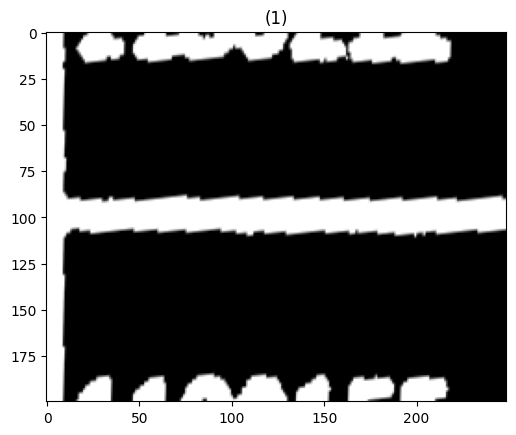

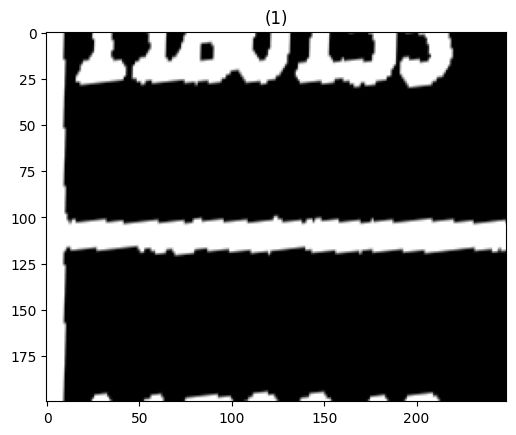

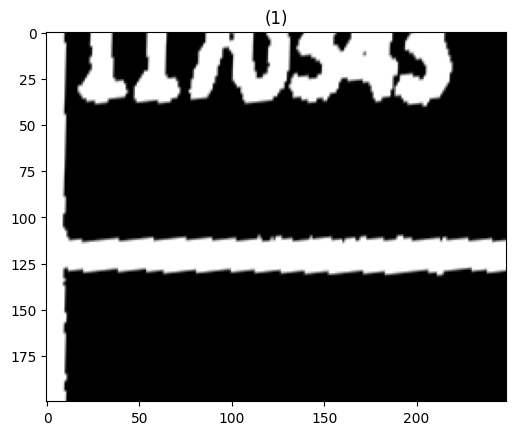

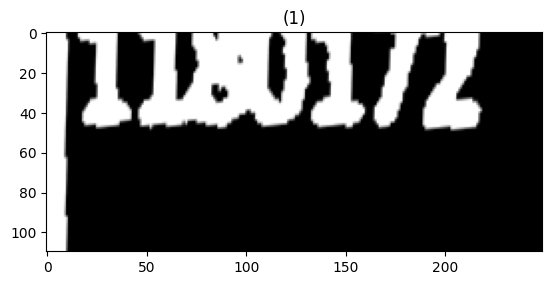

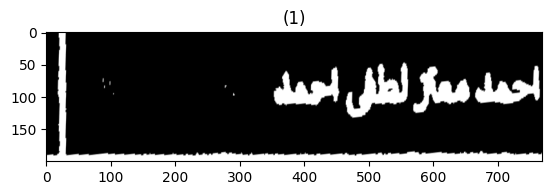

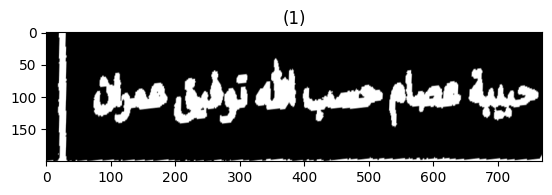

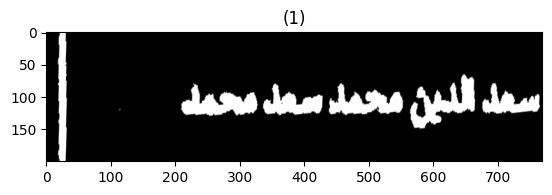

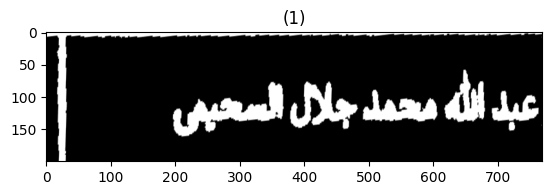

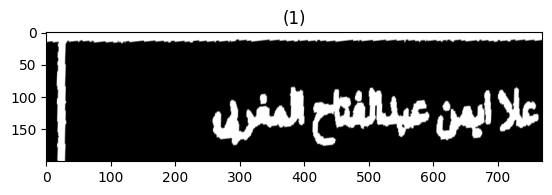

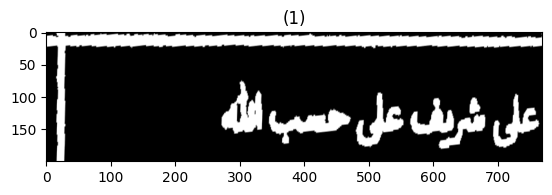

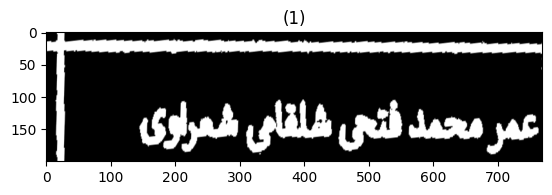

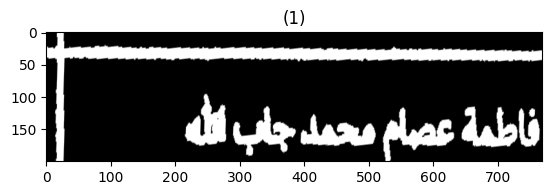

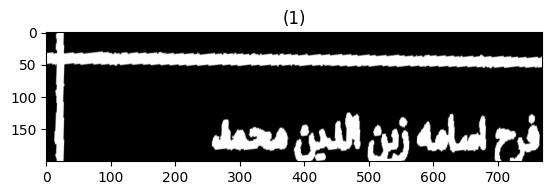

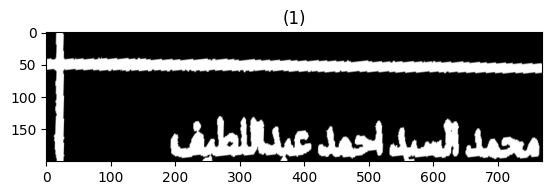

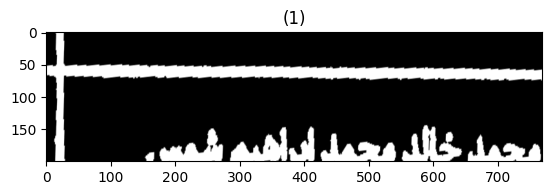

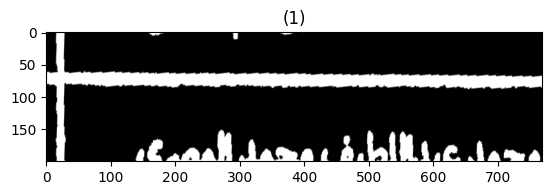

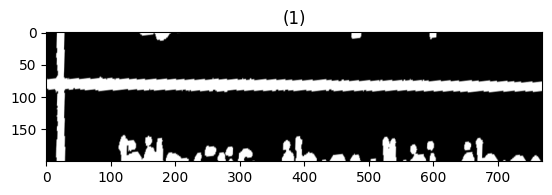

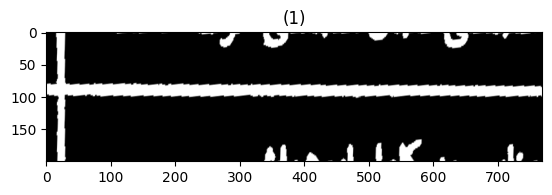

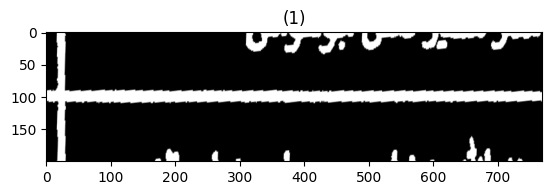

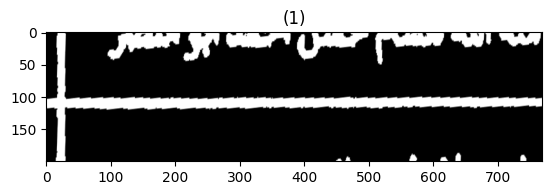

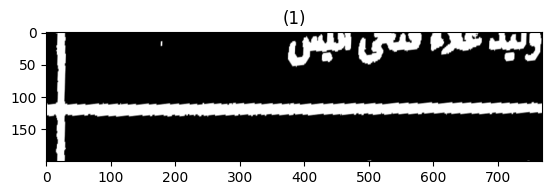

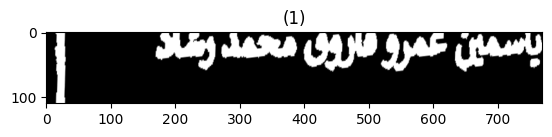

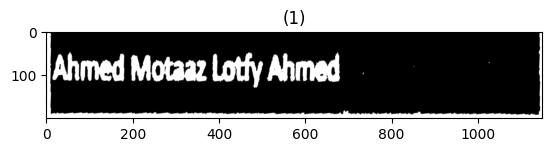

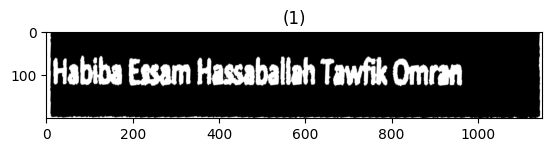

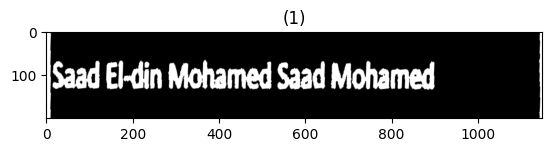

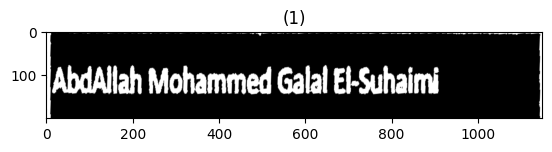

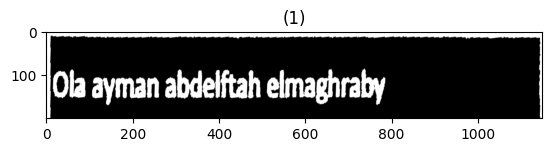

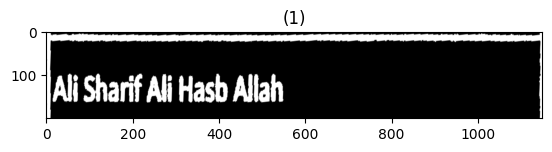

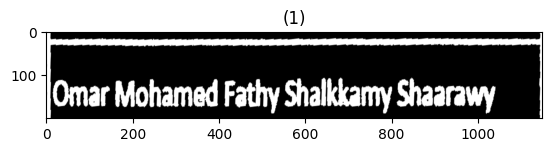

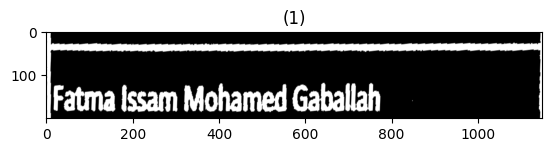

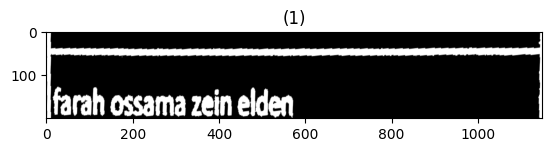

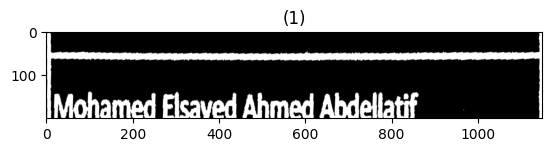

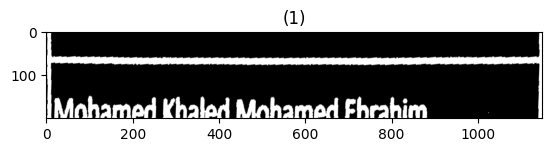

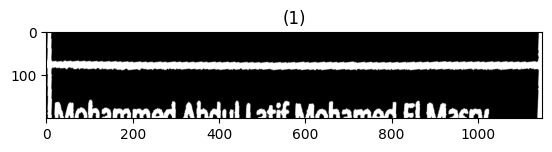

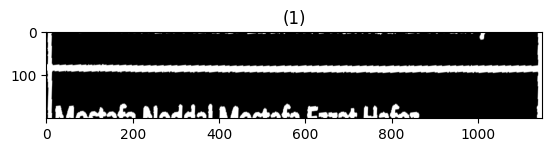

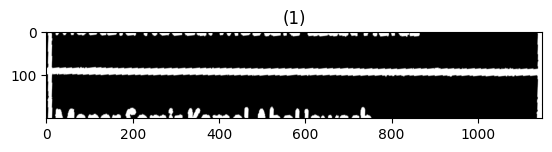

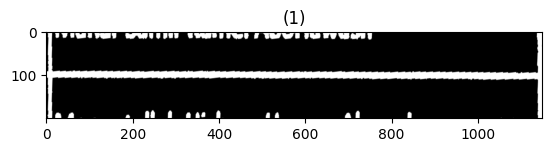

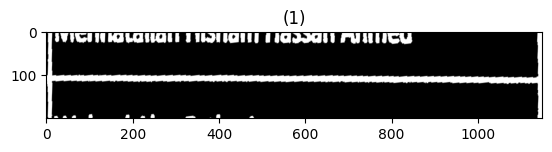

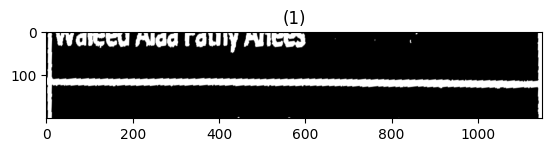

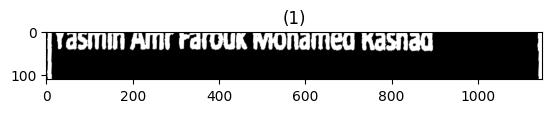

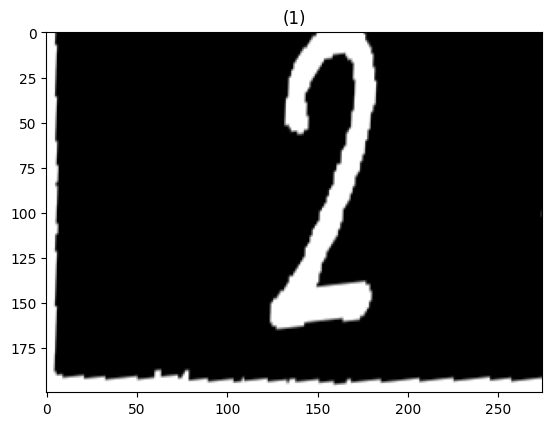

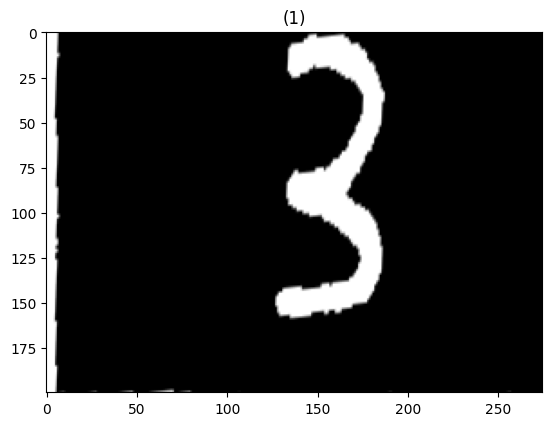

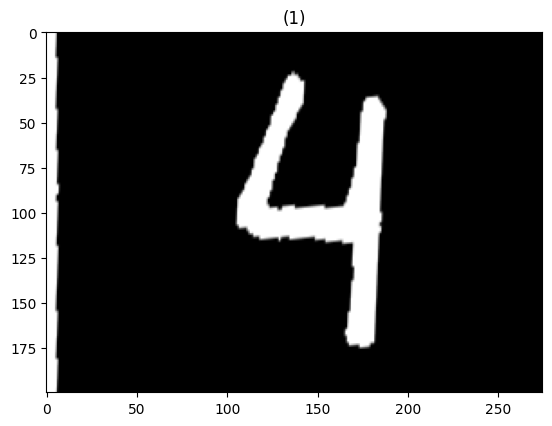

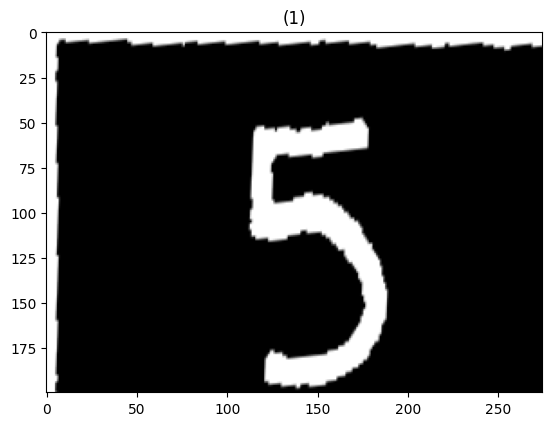

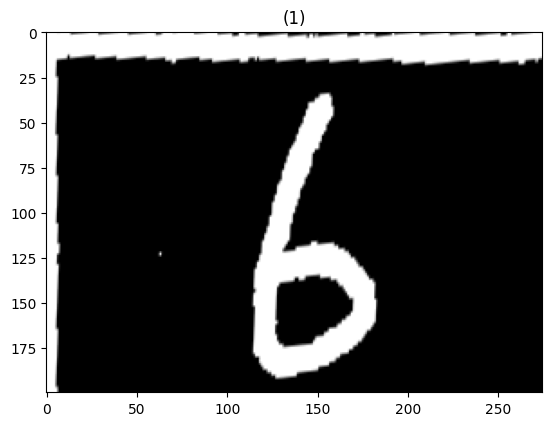

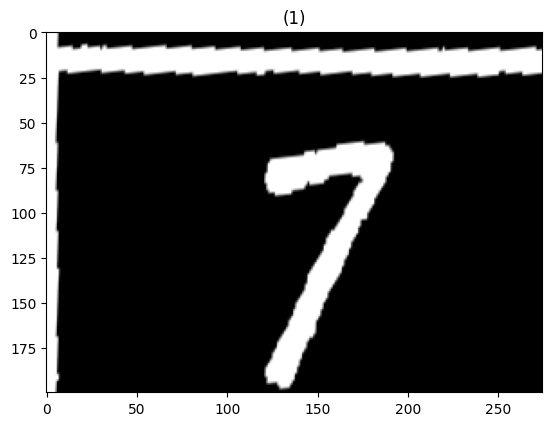

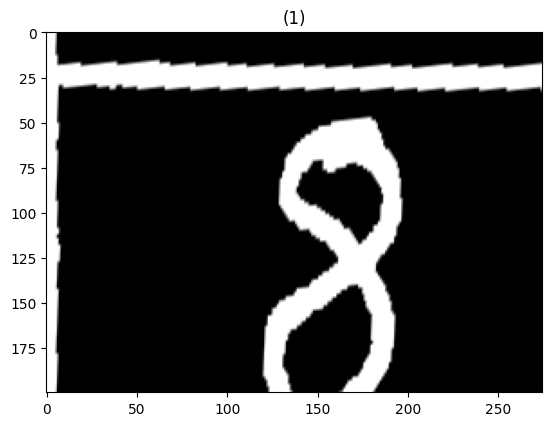

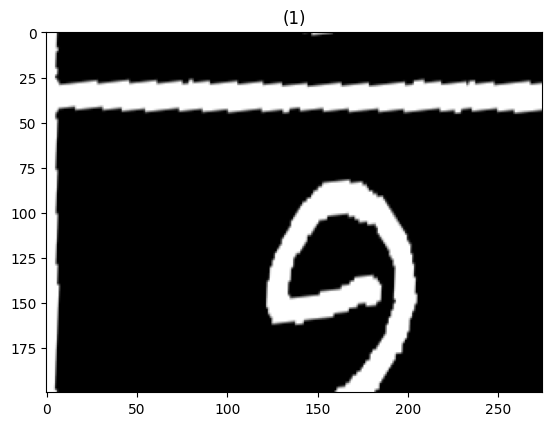

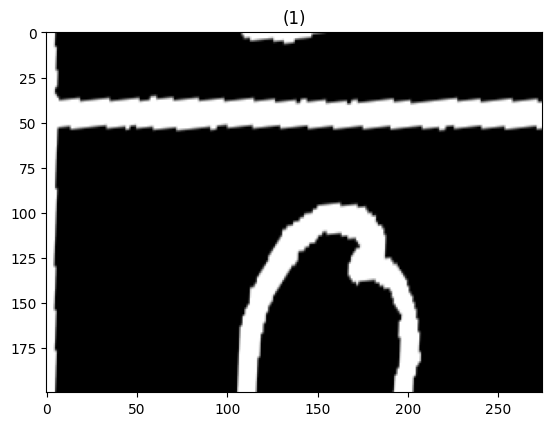

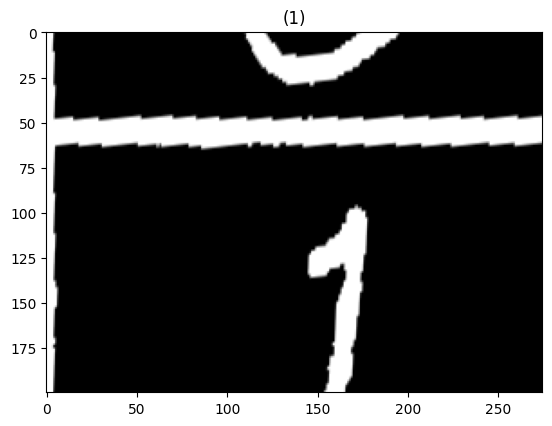

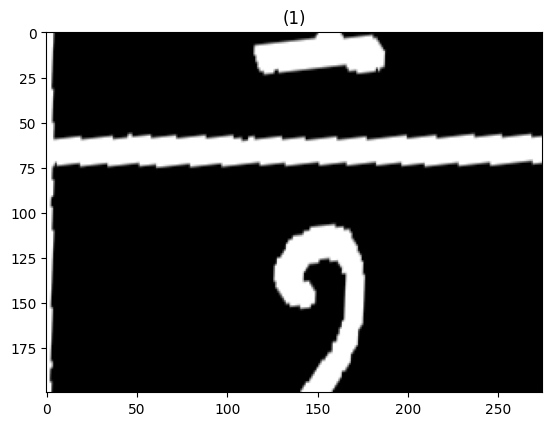

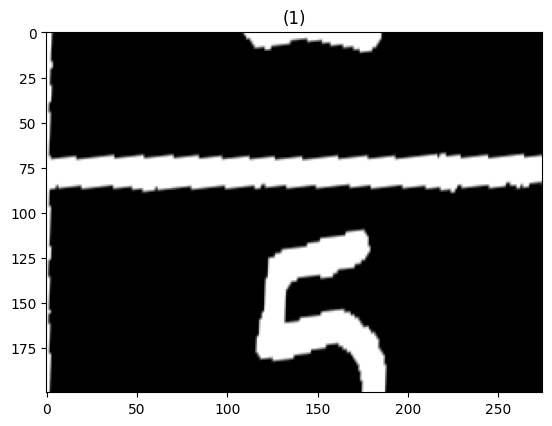

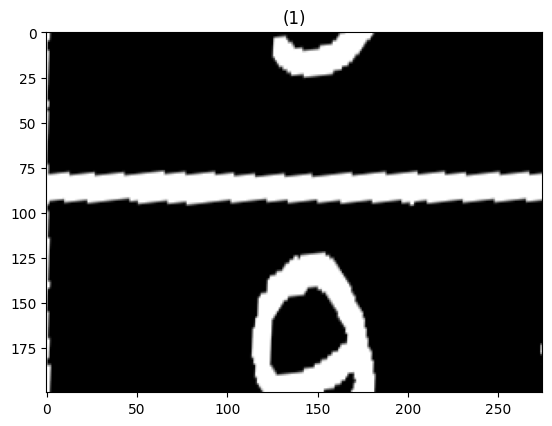

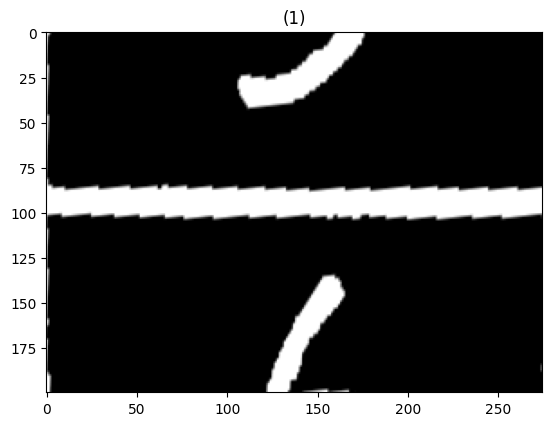

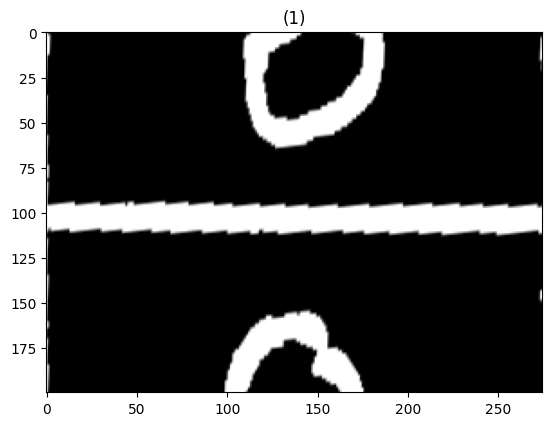

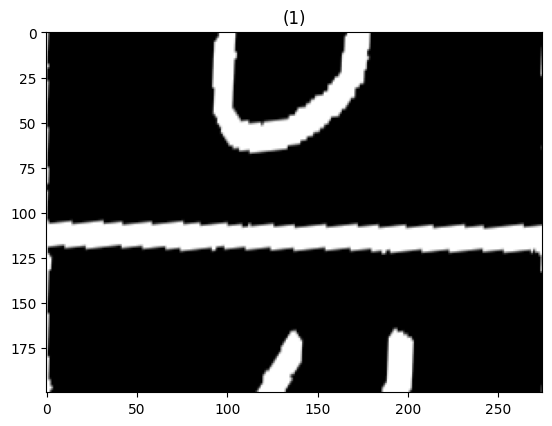

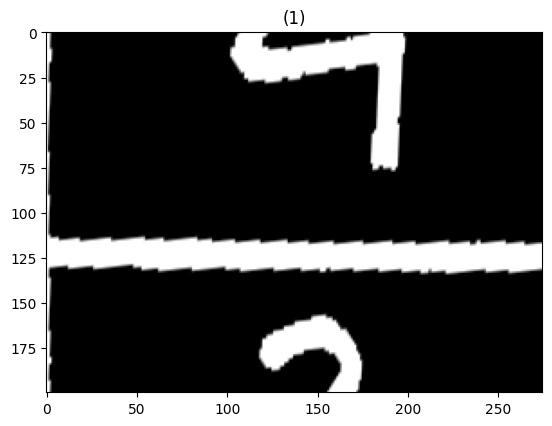

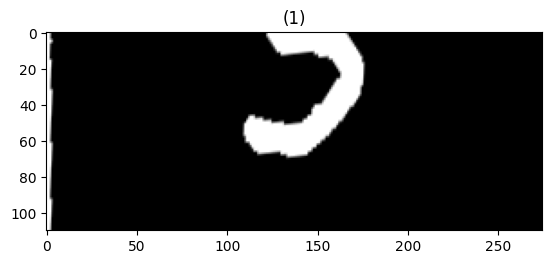

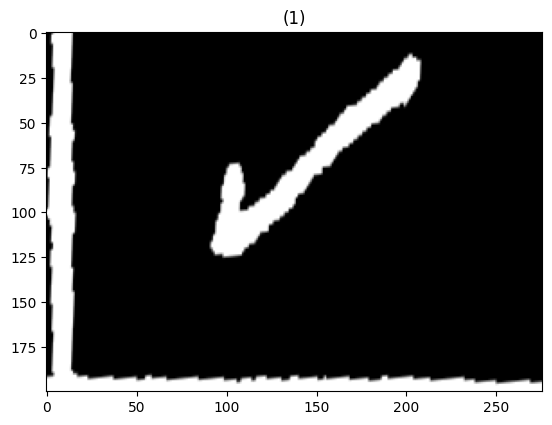

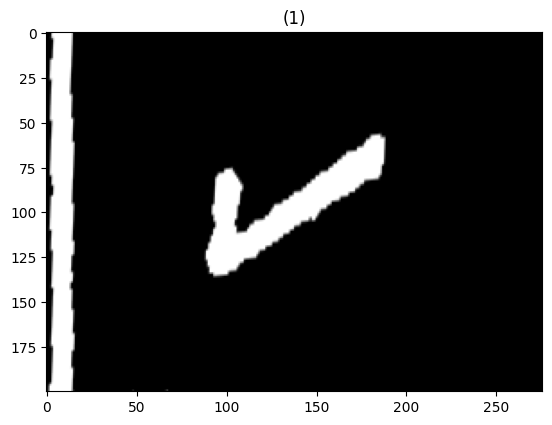

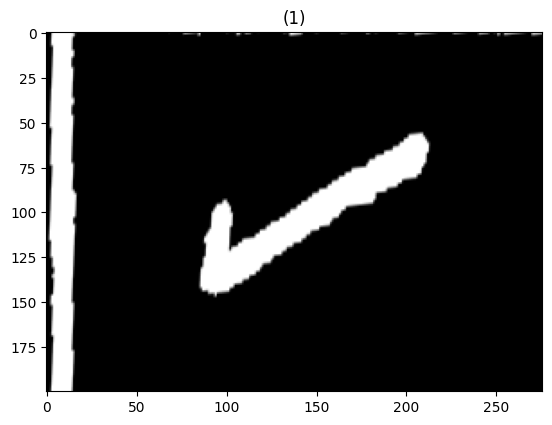

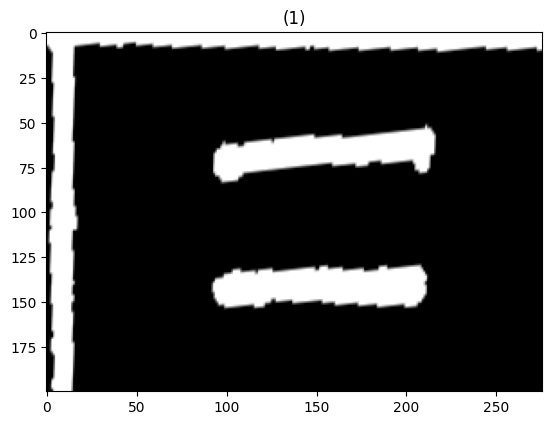

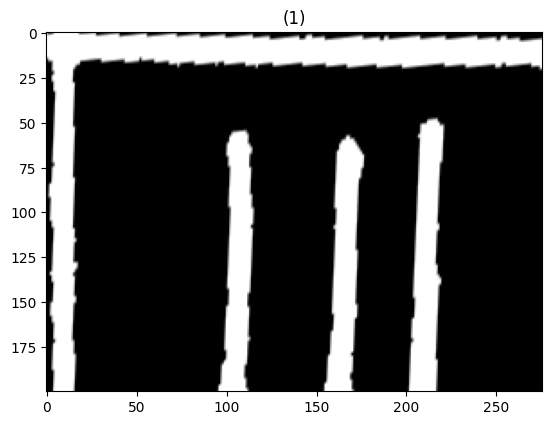

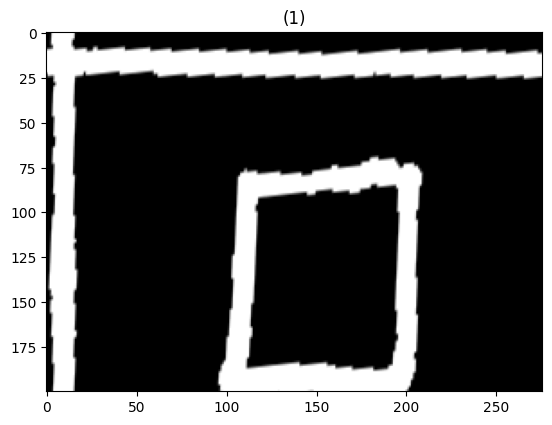

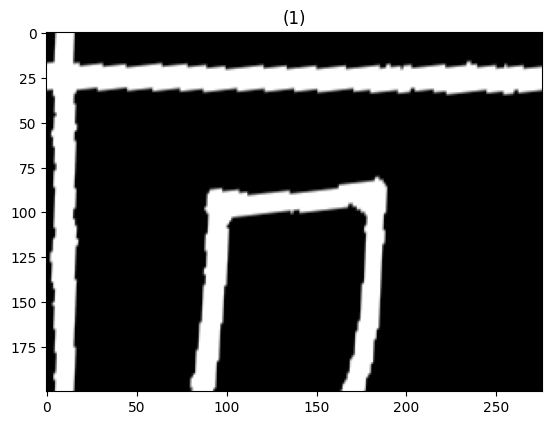

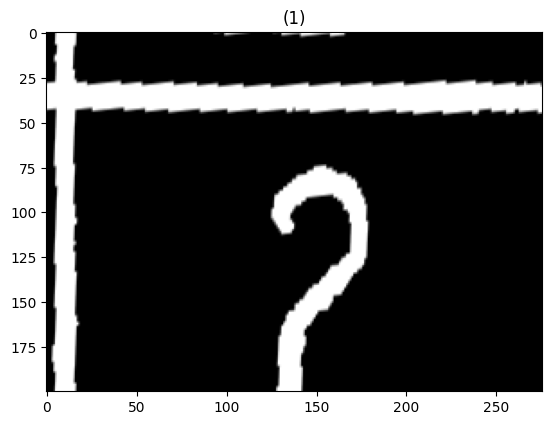

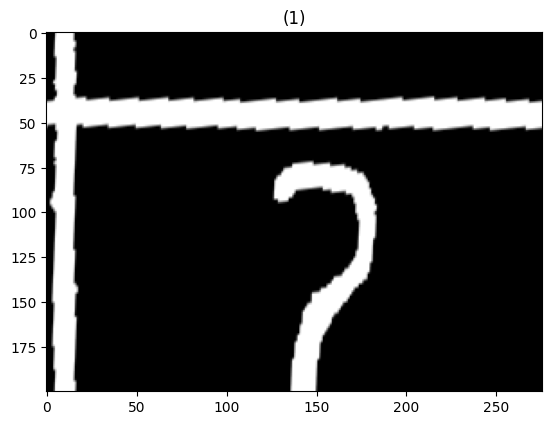

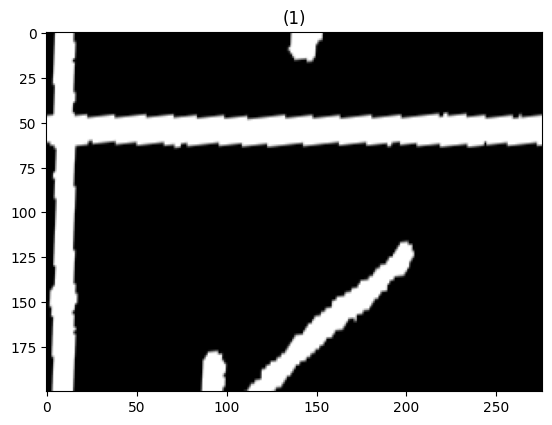

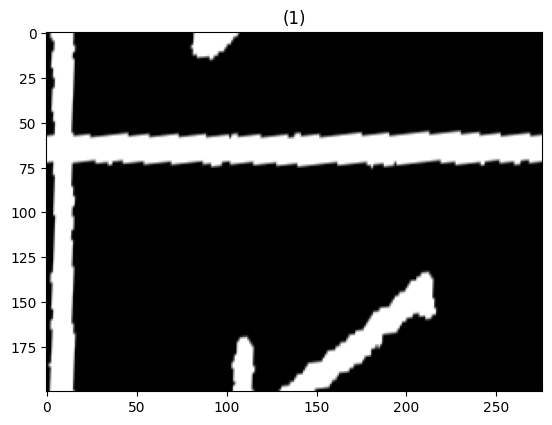

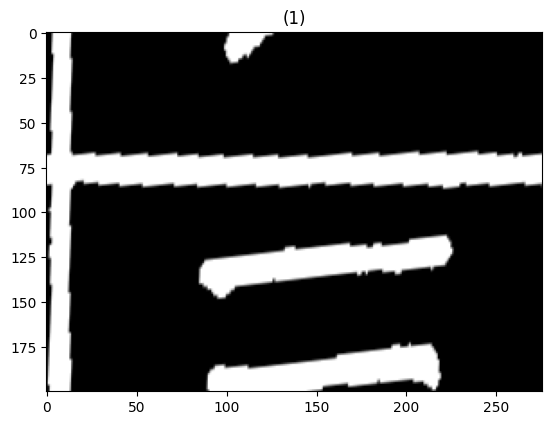

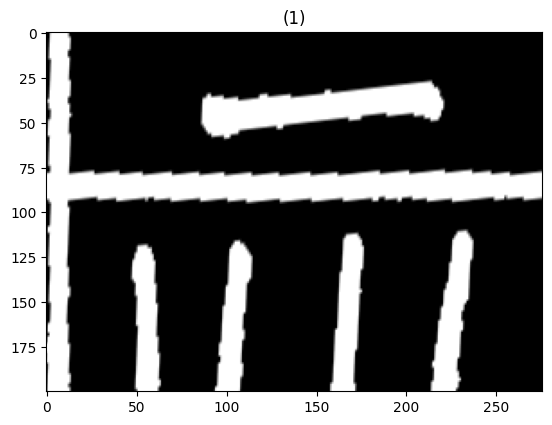

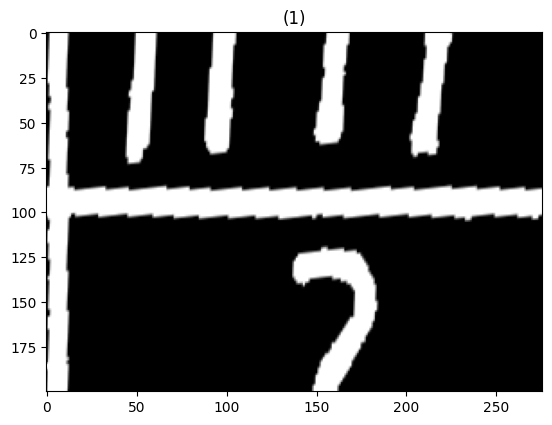

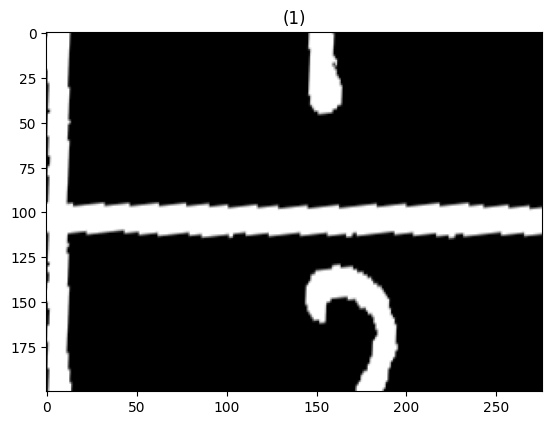

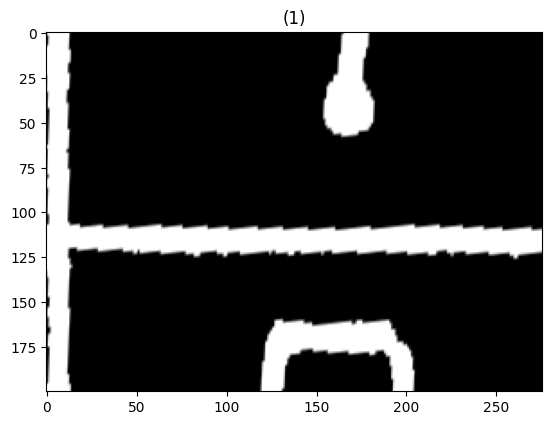

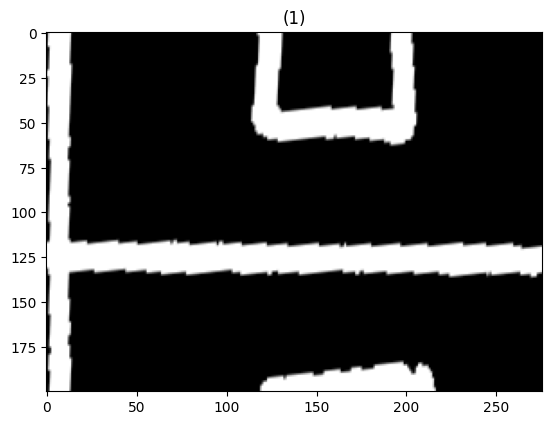

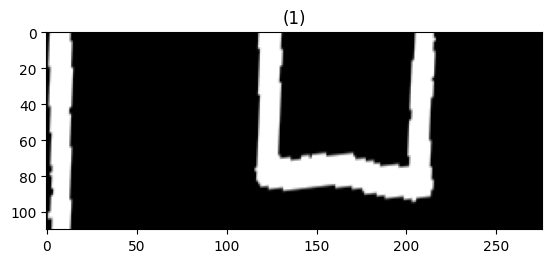

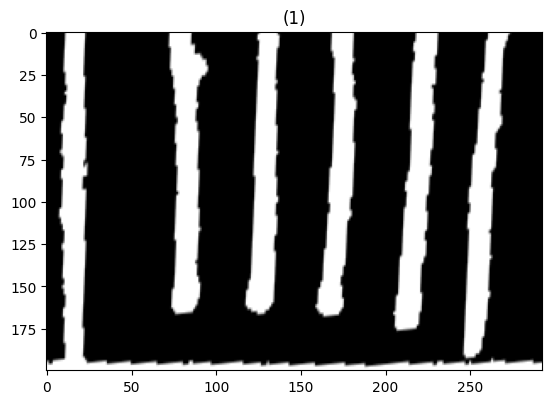

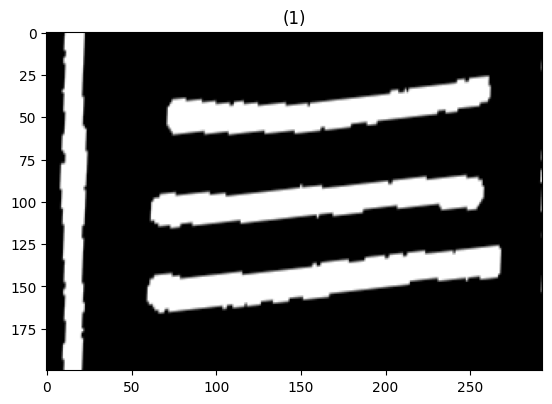

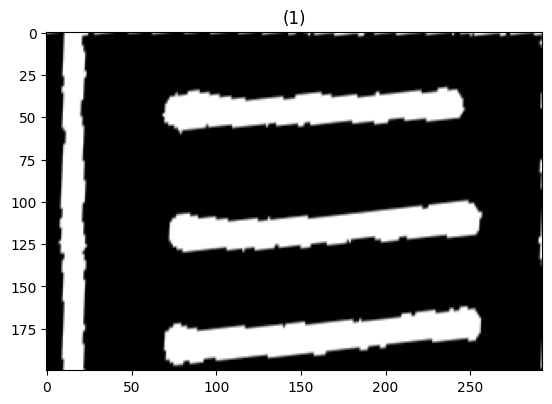

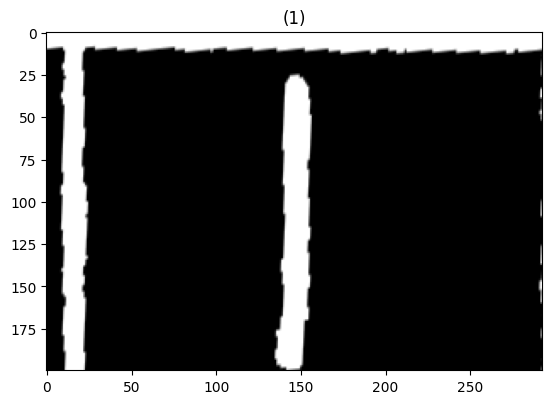

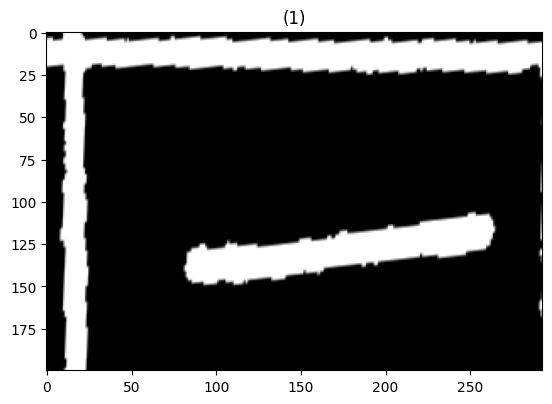

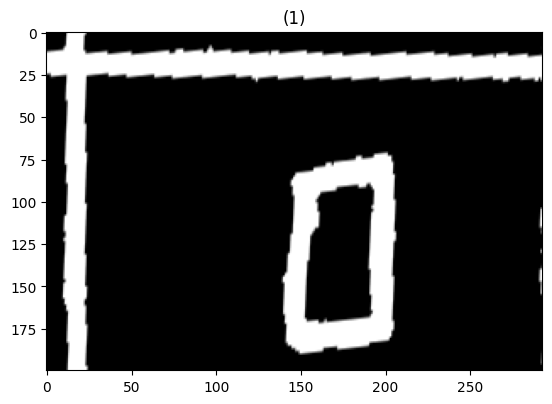

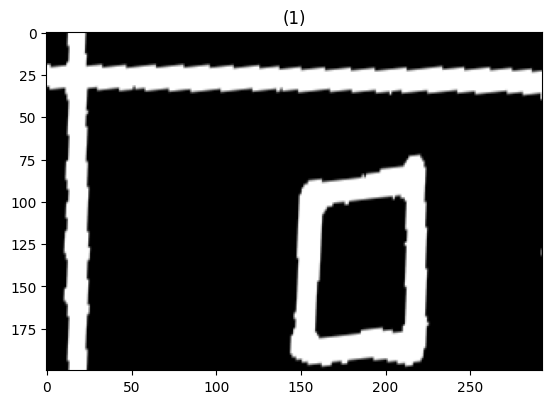

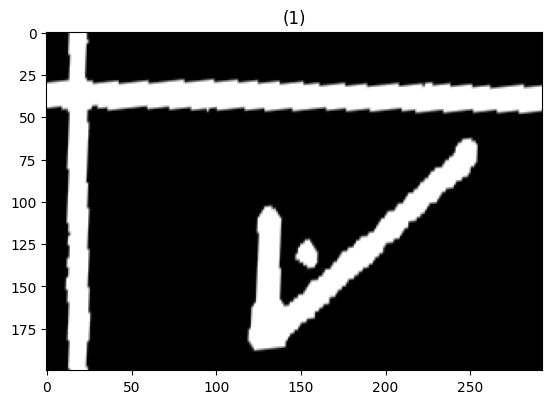

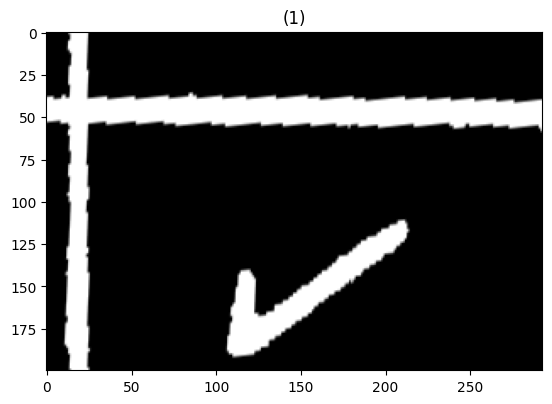

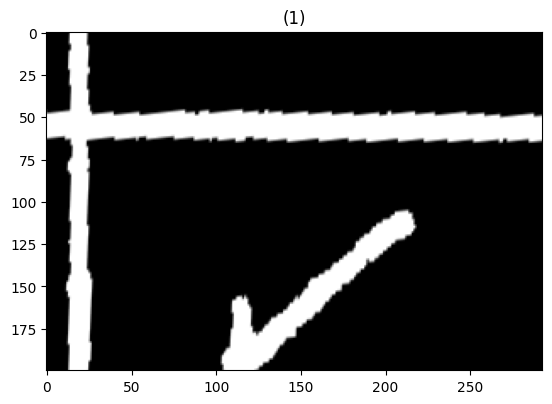

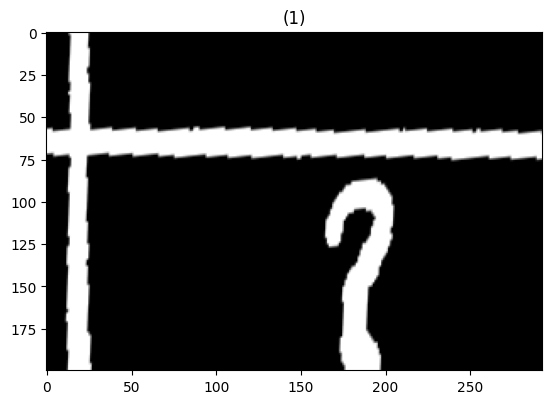

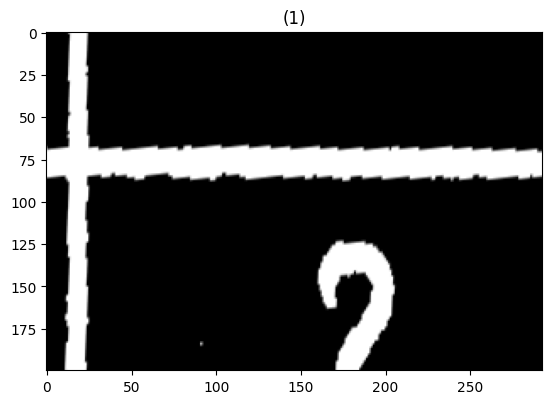

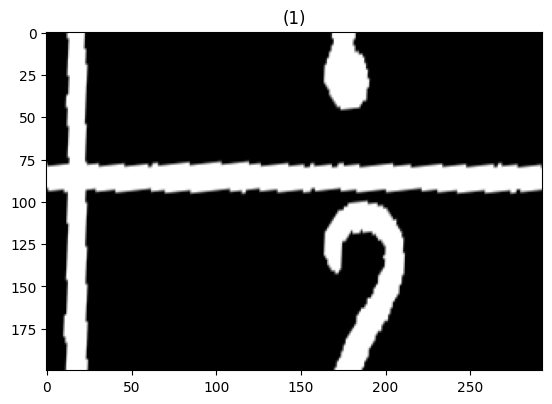

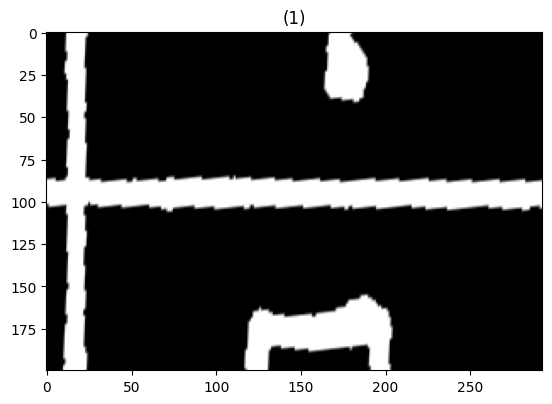

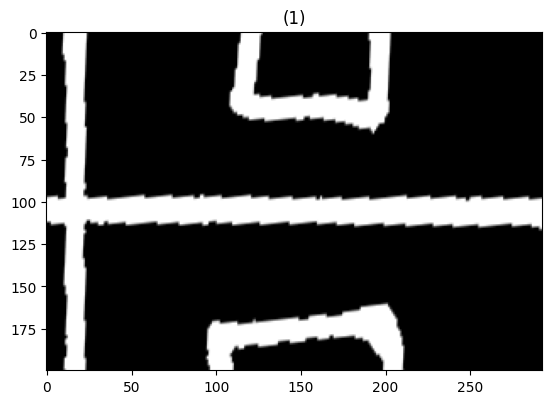

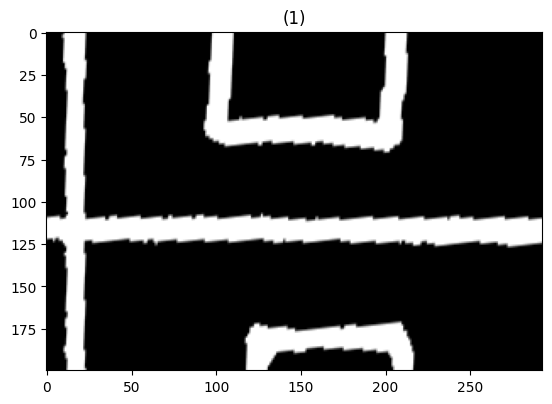

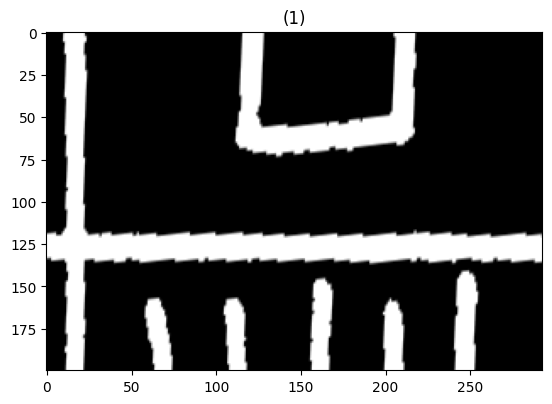

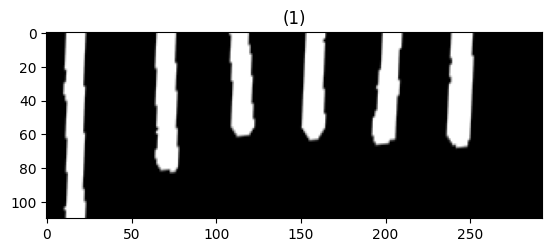

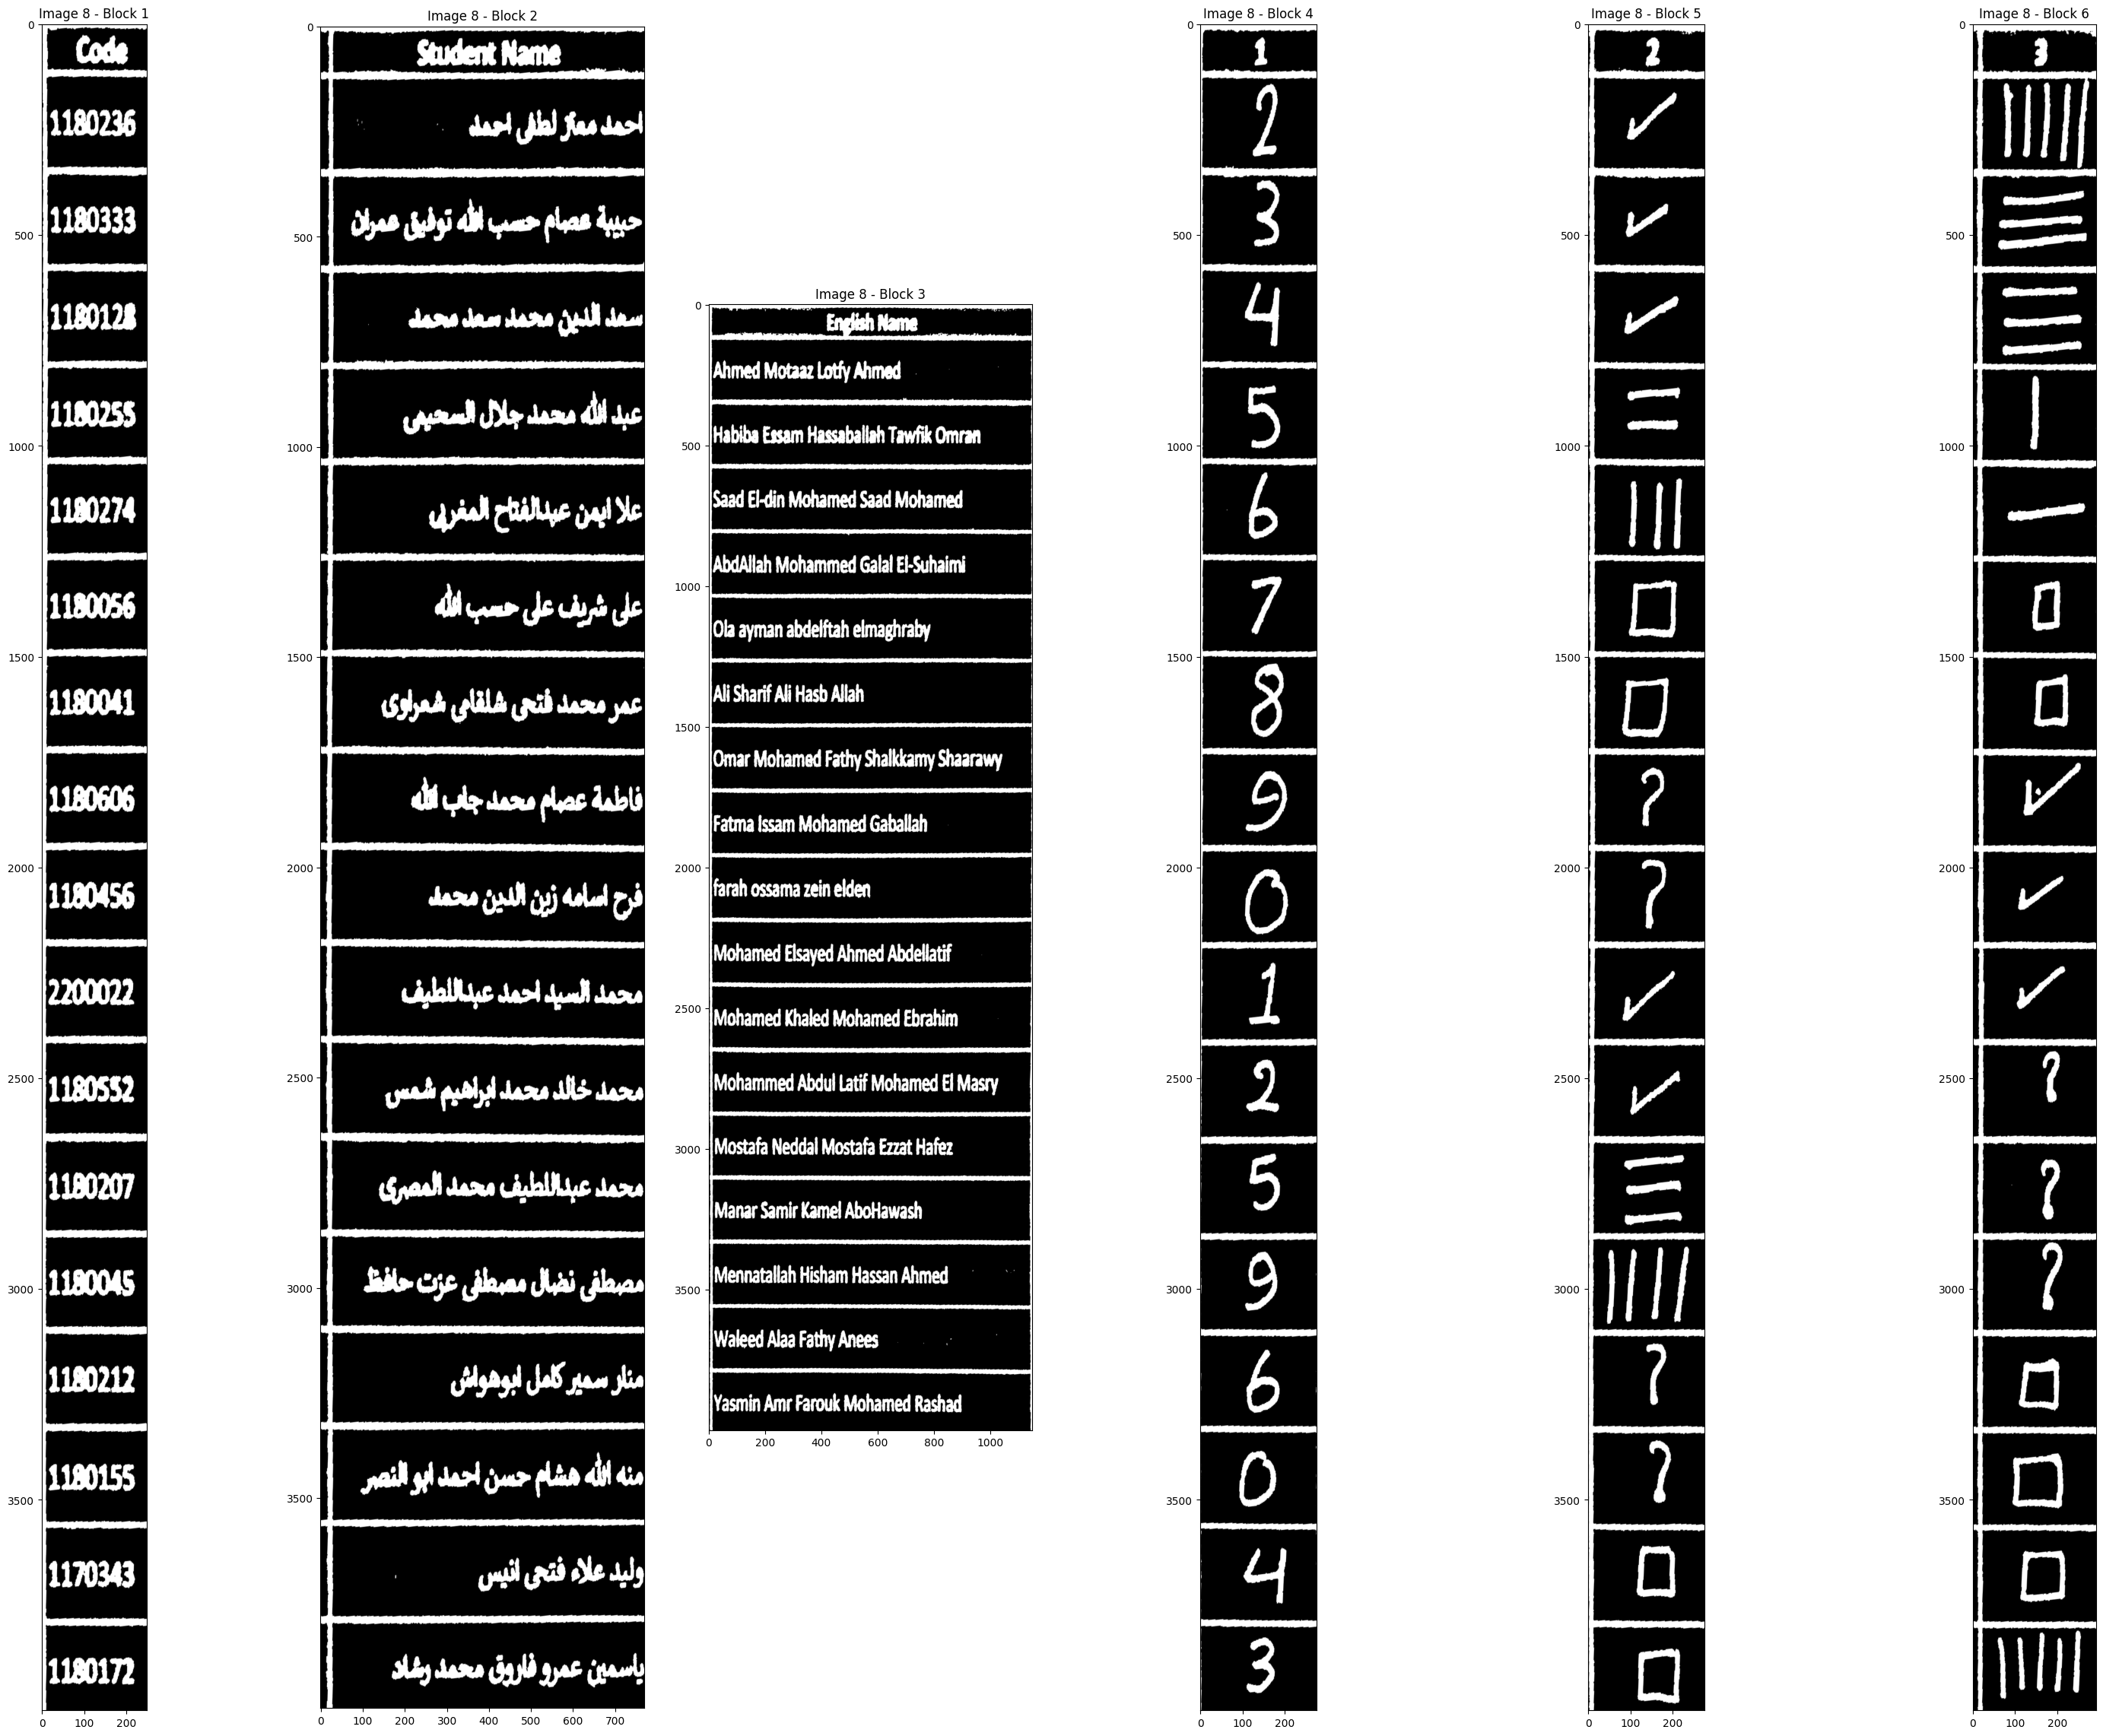

In [4]:
# Thresholds for blocks and segment indices
block_segments = [[220, 0], [760, 1], [1140, 2], [220, 3], [270, 4], [230, 5]]

# Function to process all segments and extract blocks
def process_image_segments(vertical_lines, binary_img):
    line_index = 0
    all_blocks = []
    for segment in block_segments:
        [block, new_index] = extract_blocks(vertical_lines[line_index:], segment, binary_img)
        line_index += new_index
        all_blocks.append(block)
    return all_blocks

# Main loop to process images
image_directory = 'sheets'
for img_index in range(8, 9):
    print(f"Processing Image {img_index}")
    image_path = os.path.join(image_directory, f"{img_index}.jpg")
    inverted_image = load_and_preprocess_image(image_path)
    vertical_lines = detect_vertical_lines(inverted_image)
    image_blocks = process_image_segments(vertical_lines, inverted_image)

    # Display extracted blocks
    block_labels = [f"Image {img_index} - Block {j+1}" for j in range(len(image_blocks))]
    show_images(image_blocks, block_labels)


---

## Editing contours and sorting to extract and cut cells

---

In [5]:
# Sorting function for contours
def contour_sort(x, y):
    bounding_rect_x = cv2.boundingRect(x)
    bounding_rect_y = cv2.boundingRect(y)

    if abs(bounding_rect_x[0] - bounding_rect_y[0]) <= 5:  # Compare y-coordinates if x-coordinates are close
        return bounding_rect_x[1] - bounding_rect_y[1]
    return bounding_rect_x[0] - bounding_rect_y[0]

# Sort all contours
def sorted_conts(contours):
    return sorted(contours, key=cmp_to_key(contour_sort))

# Find the largest rectangular contour
def largest_contour(contours):
    largest_contour = np.array([])
    max_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.1 * perimeter, True)
        if area > max_area and len(approx) == 4:
            largest_contour = approx
            max_area = area
    return largest_contour

# Perspective transformation
def Prespective_Transform(img_original):
    img = img_original.copy()
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.bilateralFilter(gray_image, 20, 30, 30)
    edges = cv2.Canny(gray_image, 20, 120)
    edges = cv2.dilate(edges.copy(), None, 2)

    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    biggest = largest_contour(contours[2:10])
    if biggest.size != 8:
        biggest = largest_contour(contours[0:1])

    # Transform points
    pts = biggest.reshape(4, 2)
    pts_sum = pts.sum(axis=1)
    top_left = pts[np.argmin(pts_sum)]
    bottom_right = pts[np.argmax(pts_sum)]
    pts_diff = np.diff(pts, axis=1)
    top_right = pts[np.argmin(pts_diff)]
    bottom_left = pts[np.argmax(pts_diff)]

    # Output dimensions
    bottom_width = np.linalg.norm(bottom_right - bottom_left)
    top_width = np.linalg.norm(top_right - top_left)
    right_height = np.linalg.norm(top_right - bottom_right)
    left_height = np.linalg.norm(top_left - bottom_left)
    width = max(int(bottom_width), int(top_width))
    height = max(int(right_height), int(left_height))

    # Perspective warp
    converted_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    arr = np.float32([top_left, top_right, bottom_left, bottom_right])
    matrix = cv2.getPerspectiveTransform(arr, converted_points)
    img_output = cv2.warpPerspective(img_original, matrix, (width, height))
    return img_output


## Code of old goes here
## Old
# Save an image to a specific directory
def saveImg(directory, col_name, id, img):
    Path(directory).mkdir(parents=True, exist_ok=True)
    cv2.imwrite(f"{directory}/{col_name}__{id}.jpg", img)

# Detect grid cells
def getCells(img):
    img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    (thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bin = 255 - img_bin

    filter_dim = np.array(img).shape[1] // 38
    
    v_filter = cv2.getStructuringElement(cv2.MORPH_RECT, (1, filter_dim))
    h_filter = cv2.getStructuringElement(cv2.MORPH_RECT, (filter_dim, 1))
    filter = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    v_lines = cv2.erode(img_bin, v_filter, iterations=3)
    v_lines = cv2.dilate(v_lines, v_filter, iterations=3)
    lines_ver = cv2.HoughLinesP(v_lines, 1, np.pi / 180, 40, minLineLength=10, maxLineGap=20)

    for line in lines_ver:
        for x1, y1, x2, y2 in line:
            v_lines = cv2.line(v_lines, (x1, 0), (x2, v_lines.shape[0]), (255, 255, 255), 1)

    h_lines = cv2.erode(img_bin, h_filter, iterations=4)
    h_lines = cv2.dilate(h_lines, h_filter, iterations=3)
    lines_hor = cv2.HoughLinesP(h_lines, 2, np.pi / 180, 40, minLineLength=5, maxLineGap=10)

    for line in lines_hor:
        for x1, y1, x2, y2 in line:
            h_lines = cv2.line(h_lines, (0, y1), (h_lines.shape[1], y2), (255, 255, 255), 1)

    final_img = cv2.bitwise_and(v_lines, h_lines)
    final_img = cv2.erode(~final_img, filter, iterations=1)
    (thresh, img_output) = cv2.threshold(final_img, 128,255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) 
    #show_images([img_output])
    return img_output

# Cut and save cells from the grid
def cutCells(img, original_img, output_dir):
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted_conts(contours)
    rows = []

    for c in range(len(contours) - 1):
        x1, y1, w1, h1 = cv2.boundingRect(contours[c])
        x2, y2, w2, h2 = cv2.boundingRect(contours[c + 1])
        if x1 == x2:
            rows.append(y1)
        else:
            rows.append(y1)
            break

    num_hor = len(rows)
    arr = ["Student_ID", "Arabic_Name", "English_Name", "Col1", "Col2", "Col3"]
    for col in range(6):
        for row in range(1, num_hor - 1):
            x1, y1, w1, h1 = cv2.boundingRect(contours[row + num_hor * col])
            x2, y2, w2, h2 = cv2.boundingRect(contours[row + 1 + num_hor * col])
            x3, y3, w3, h3 = cv2.boundingRect(contours[row + num_hor * col + num_hor + 1])
            new_img = original_img[y1 + h1 : y3, x2 + w2 : x3]
            #inverted_cell = 255 - new_img  # Invert the cell image
            saveImg(output_dir, arr[col], row, new_img)

#### Outputting the cut cells of each sheet into a directory

In [6]:
sheet_samples_dir = 'sheets'
output_dir = "Output_Result"

# Make sure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for name in os.listdir(sheet_samples_dir):
    f_path = os.path.join(sheet_samples_dir, name)
    print(name)
    img = cv2.imread(f_path)
    
    aligned_img = Prespective_Transform(img) 
    gray_img = cv2.cvtColor(aligned_img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    
    final_img = getCells(gray_img) 
    
    img_name = os.path.splitext(name)[0]  # Get the name without extension
    
    # Create a new directory for each processed image
    new_directory = os.path.join(output_dir, img_name)
    
    # Make sure the new directory exists
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)
    
    # Call the function to cut cells and save them
    cutCells(final_img, gray_img, new_directory)

1.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg


---

## Using a pretarained OCR model to extract numbers

---

In [7]:
def ocr_pytesseract_number_extraction_module2(image):
    # Open the image using Pillow
    if os.path.exists(image_path):
        extracted_text = pytesseract.image_to_string(image, config='--psm 6 -c tessedit_char_whitelist=0123456789')
    else:
        print(f"File not found: {image_path}")
    #you can remove the config to detect the text if you want but we only using it for digits detection
    extracted_text = pytesseract.image_to_string(image, config='--psm 6 -c tessedit_char_whitelist=0123456789')
    return extracted_text
print(ocr_pytesseract_number_extraction_module2('Output_Result/1/Col1__9.jpg'))

9



In [8]:
def ocr_pytesseract_number_extraction(img):
    if img is None:
        print("Error: Unable to load the image.")
        return None

    # Ensure the image is in grayscale format
    if len(img.shape) == 3 and img.shape[2] == 3:
        # Convert color image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif len(img.shape) == 2:
        # Already in grayscale, no need to convert
        gray = img
    else:
        print("Error: Invalid image format.")
        return None


    # Apply thresholding to the grayscale image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # Use pytesseract to perform OCR on the image with custom configurations
    custom_config = r'--oem 3 --psm 10 outputbase digits'
    text = pytesseract.image_to_string(binary, config=custom_config)

    return text

# Path to your handwritten digits image
image_path = 'Output_Result/1/Col1__14.jpg'
img=cv2.imread(image_path)
# Perform handwritten digit detection with adjusted thresholding and configurations
result = ocr_pytesseract_number_extraction(img)

print("Detected handwritten digits:")
print(result)

Detected handwritten digits:
2



---

## Manually trianed digits classifier

---

Will use the SVM model applied in the classification lab

In [9]:
# Define the random seed
random_seed = 30  # You can use any integer value

target_img_size = (32, 32)
classifiers = {
    'SVM': svm.LinearSVC(random_state=random_seed),
}

def extract_hog_features(img):
    # Extract HOG features from an image
  
    img = cv2.resize(img, dsize=target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

# Function to load dataset digits
def load_dataset_digits(folder):
    features = []
    labels = []
    for digit in range(10):  # Folders named 0, 1, 2, ..., 9 for digits
        symbol_folder = os.path.join(folder, str(digit))
        symbol_files = os.listdir(symbol_folder)
        for filename in symbol_files:
            if filename.endswith(".jpg"):
                img_path = os.path.join(symbol_folder, filename)
                img = cv2.imread(img_path, 0)  # Load image in grayscale
                if img is not None:
                    features.append(extract_hog_features(img))
                    labels.append(digit)
    return np.array(features), np.array(labels)

# Load the digits dataset
digs_feats, digs_labels = load_dataset_digits('datasets/Digs_dataset/')

# Split the dataset into train and test sets
digits_train_features, digits_test_features, digits_train_labels, digits_test_labels = train_test_split(
    digs_feats, digs_labels, test_size=0.2, random_state=random_seed)

# Train and evaluate the model for digits
digits_model = {}
for model_name, model in classifiers.items():
    print('--------------- Training digits dataset', model_name, "---------------")
    
    # Train the model only on the training features
    model.fit(digits_train_features, digits_train_labels)
    
    # Test the model on images it hasn't seen before
    accuracy = model.score(digits_test_features, digits_test_labels)
    
    print(model_name, 'accuracy:', accuracy * 100, '%')

    digits_model[model_name] = model

# Save the digits models
dump(digits_model, 'Digits_trained_model.joblib')
print('Digits model successfully saved!')



--------------- Training digits dataset SVM ---------------
SVM accuracy: 60.0 %
Digits model successfully saved!


Loaded digits model successfully!
{'SVM': LinearSVC(random_state=30)}


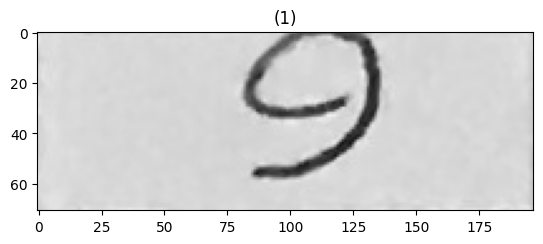

[9]


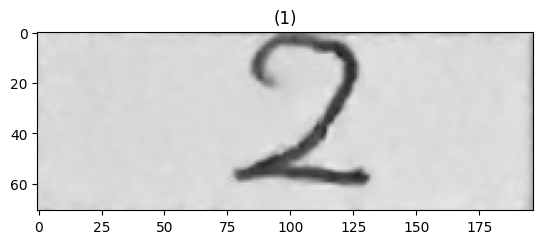

[2]


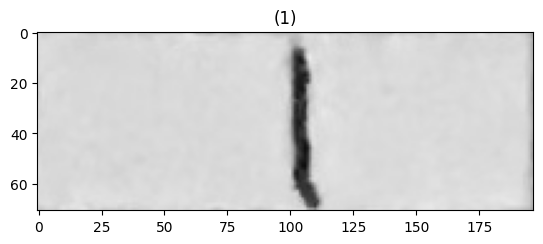

[1]


In [10]:
def load_model():
    # Load the digits models dictionary
    digs_model = load('Digits_trained_model.joblib')
    print('Loaded digits model successfully!')
    print(digs_model)
    return digs_model

digs_model = load_model()

def digits_prediction(img):
    test_features=extract_hog_features(img)
    predicted_digit=digs_model['SVM'].predict([test_features])
    return predicted_digit

img=cv2.imread("Output_Result/1/Col1__12.jpg")
show_images([img])
print(digits_prediction(img))

img=cv2.imread("Output_Result/1/Col1__2.jpg")
show_images([img])
print(digits_prediction(img))

img=cv2.imread("Output_Result/1/Col1__1.jpg")
show_images([img])
print(digits_prediction(img))

---

## Manual symbols classifier

---

In [11]:
# Function to load dataset symbols
def load_dataset_symbols(folder):
    feats = []
    labels = []
    symbols = os.listdir(folder)  
    for symbol in symbols:
        symbol_folder = os.path.join(folder, symbol)
        symbol_files = os.listdir(symbol_folder)
        for filename in symbol_files:
            if filename.endswith(".jpg"):
                img_path = os.path.join(symbol_folder, filename)
                img = cv2.imread(img_path, 0)  # Load image in grayscale
                if img is not None:
                    feats.append(extract_hog_features(img))
                    labels.append(symbol)  # Label is the folder name 
    return np.array(feats), np.array(labels)

# Load the symbols dataset
symbs_feats, symbs_labels = load_dataset_symbols('datasets/Symbs_dataset')

# Split the dataset into train and test sets
symbols_train_features, symbols_test_features, symbols_train_labels, symbols_test_labels = train_test_split(
    symbs_feats, symbs_labels, test_size=0.2, random_state=random_seed)

# Train and evaluate the model for symbols
symbols_model = {}
for model_name, model in classifiers.items():
    print('--------------- Training symbols dataset', model_name, "---------------")
    
    # Train the model only on the training features
    model.fit(symbols_train_features, symbols_train_labels)
    
    # Test the model on images it hasn't seen before
    accuracy = model.score(symbols_test_features, symbols_test_labels)
    
    print(model_name, 'accuracy:', accuracy * 100, '%')

    symbols_model[model_name] = model

# Save the symbols models
dump(symbols_model, 'Symbols_trained_model.joblib')
print('Symbols model saved successfully!')

--------------- Training symbols dataset SVM ---------------
SVM accuracy: 84.61538461538461 %
Symbols model saved successfully!


Loaded symbols model successfully!
{'SVM': LinearSVC(random_state=30)}


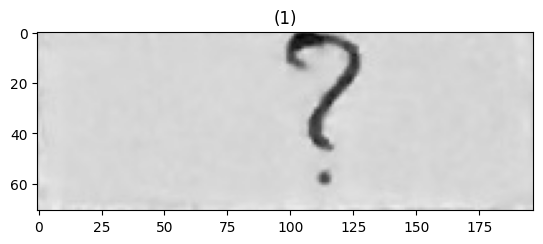

question


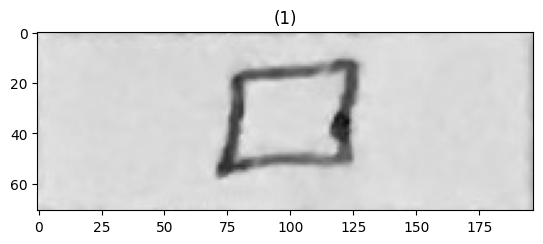

box


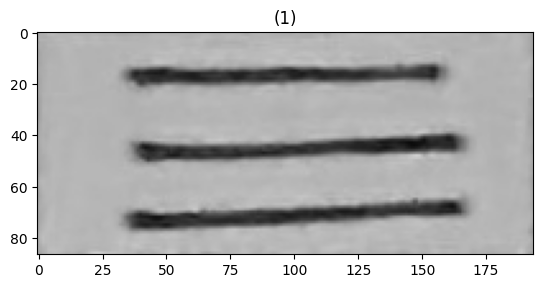

horizontal3


In [12]:
def load_symbols_model():
    # Load the digits models dictionary
    symbs_model = load('Symbols_trained_model.joblib')
    print('Loaded symbols model successfully!')
    print(symbs_model)
    return symbs_model

symbs_model = load_symbols_model()

""" def symbols_prediction(img):
    test_features1=extract_hog_features(img)
    predicted_symbol=symbs_model['SVM'].predict([test_features1])
    return predicted_symbol """

def symbols_prediction(img):
    # Extract features from the image using HOG
    test_features = extract_hog_features(img)
    
    # Predict the symbol using the pre-trained SVM model
    predicted_symbol = symbs_model['SVM'].predict([test_features])
    
    # Ensure the output is returned as a string
    return str(predicted_symbol[0])


img=cv2.imread("Output_Result/1/Col2__12.jpg")
show_images([img])
print(symbols_prediction(img))

img=cv2.imread("Output_Result/1/Col2__2.jpg")
show_images([img])
print(symbols_prediction(img))

img=cv2.imread("Output_Result/6/Col3__3.jpg")
show_images([img])
print(symbols_prediction(img))

---

## ID and answers extraction

---

In [13]:
def sort_columns(filename):
    # Extract the numeric part of the filename for sorting
    return int(''.join(filter(str.isdigit, filename)))

#### Handling IDs into seperate digits

In [27]:
def process_ids_from_path(ids_dir):  
    """
    Process ID images from a directory, extract digits or components from each ID image,
    and return a dictionary of extracted components grouped by ID.

    Parameters:
    - ids_dir: str, the path to the directory containing the ID images.

    Returns:
    - extracted_ids: dict, where keys are ID filenames and values are lists of extracted digit images.
    """
    ids_dir = str(ids_dir)
    extracted_ids = {}
    image_files = [f for f in os.listdir(ids_dir) if f.endswith(('.jpg', '.png'))]  # Supported formats

    for img_file in image_files:
        # Read the image
        img_path = os.path.join(ids_dir, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Error: Unable to read {img_file}. Skipping...")
            continue

        # Convert the image to grayscale
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img

        # Binarize the image (invert threshold for better contour detection)
        _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)

        # Find contours of the digits/components
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])  # Sort left-to-right

        # Extract and save each digit/component
        digit_images = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > 5 and h > 10:  # Filter noise based on size
                digit = gray[y:y + h, x:x + w]
                digit_images.append(digit)

        # Save the extracted digits/components
        extracted_ids[img_file] = digit_images

    return extracted_ids



' def split_digits_from_image(image):\n    #Split individual digits or regions from a given image\n    gray = image if len(image.shape) == 2 else cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\n    _, binary = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)\n    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\n    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])\n\n    digit_regions = []\n    for contour in contours:\n        x, y, w, h = cv2.boundingRect(contour)\n        digit_regions.append(gray[y:y + h, x:x + w])\n\n    return digit_regions '

In [42]:
def process_ids_from_pathNEW(images): #################
    # Check if the image is already in grayscale
    if len(img.shape) == 2:
        gray = img
    else:
        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use adaptive thresholding to create a binary image
    _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
    # Experiment with the threshold value (128 in this case) to suit your needs

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])
    
    # Array to store the extracted digits
    digit_images = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        digit = gray[y:y + h, x:x + w]

        digit_images.append(digit)

    return digit_images


#### Images loading from directory and grouping the columns

In [43]:
def load_images_for_prediction(base_dir):
    gradesheets = {}
    
    # Traverse all subdirectories within the base directory
    for gradesheet_dir in os.listdir(base_dir):
        gradesheet_path = os.path.join(base_dir, gradesheet_dir)
        
        if not os.path.isdir(gradesheet_path):  # Skip non-directory files
            continue
        
        # Initialize storage for this gradesheet
        grouped_images = {"Student_ID": [], "Col1": [], "Col2": [], "Col3": []}
        
        # Process files within the current gradesheet directory
        for file_name in os.listdir(gradesheet_path):
            file_path = os.path.join(gradesheet_path, file_name)
            
            if file_name.startswith("Student_ID"):
                grouped_images["Student_ID"].append(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE))
            elif file_name.startswith("Col1"):
                grouped_images["Col1"].append(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE))
            elif file_name.startswith("Col2"):
                grouped_images["Col2"].append(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE))
            elif file_name.startswith("Col3"):
                grouped_images["Col3"].append(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE))
        
        # Store grouped images for the current gradesheet
        gradesheets[gradesheet_dir] = grouped_images

    return gradesheets

#### Predict the IDs and columns

#### Encodings:
1. Digits : digit as is
2. Empty : Zero
3. Square : Zero
4. ? : Red empty cell
5. Checkmark : 5
6. Horizontal : 5 - no. of lines
7. Vertical : no. of lines

In [49]:
def predict_student_ids(images, method="SVM"):  #######################
    """
    Predict numeric IDs from images using OCR or SVM.
    Parameters:
    - images: List of ID images (grayscale).
    - method: Prediction method ("OCR" or "SVM").
    Returns:
    - List of predicted IDs.
    """
    predictions = []
    for image in images:
        if method == "OCR":
            predictions.append(ocr_pytesseract_number_extraction_module2(image))  # Extract ID using OCR
        elif method == "SVM":
            # Split the image into individual digit images (using code_split)
            digit_images = process_ids_from_path(image)  # Assume 'process_ids_from_image' handles NumPy arrays
            id = ""
            for digit in digit_images:
                predicted = digits_prediction(digit)
                id += str(predicted[0])
            predictions.append(id)
    return predictions


def predict_column1_answers(images, method="SVM"):
    """
    Predict answers for column 1 using OCR or SVM.
    Parameters:
    - images: List of column 1 images (grayscale).
    - method: Prediction method ("OCR" or "SVM").
    Returns:
    - List of predicted answers for column 1.
    """
    predictions = []
    for image in images:
        if method == "OCR":
            predictions.append(ocr_pytesseract_number_extraction(image))  # Extract answer using OCR
        elif method == "SVM":
            predictions.append(str(digits_prediction(image)[0]))  # Predict answer using SVM
    return predictions



def predict_column2_3_scores(images):
    """
    Predict scores or symbols for columns 2 and 3.
    Parameters:
    - images: List of column 2/3 images (grayscale).
    Returns:
    - List of predicted scores or symbols for columns 2/3.
    """
    predictions = []
    for image in images:
        symbol = symbols_prediction(image)  # Predict symbol
        if symbol == "checkmark":
            predictions.append(5)
        elif symbol == "square":
            predictions.append(0)
        elif symbol.startswith("horizontal"):
            predictions.append(5 - int(symbol.split('l')[1]))  # Calculate score based on horizontal lines
        elif symbol.startswith("vertical"):
            predictions.append(int(symbol.split('l')[1]))  # Calculate score based on vertical lines
        else:
            predictions.append(symbol)  # Fallback to the raw symbol if not recognized
    return predictions

#### Testing

In [52]:
# Base directory containing gradesheet images
base_dir = "Output_Result"

# Load images for prediction
gradesheet_data = load_images_for_prediction(base_dir)

# Predict for each gradesheet
for gradesheet, grouped_images in gradesheet_data.items():
    print(f"Processing gradesheet: {gradesheet}")
    
    # Predict IDs
    id_images = grouped_images["Student_ID"]
    id_predictions = predict_student_ids(id_images, method="OCR")
    print(f"Predicted IDs: {id_predictions}")
    
    # Predict column 1 answers
    col1_images = grouped_images["Col1"]
    col1_predictions = predict_column1_answers(col1_images, method="SVM")
    print(f"Predicted Column 1 Answers: {col1_predictions}")
    
    # Predict column 2 scores
    col2_images = grouped_images["Col2"]
    col2_predictions = predict_column2_3_scores(col2_images)
    print(f"Predicted Column 2 Scores: {col2_predictions}")
    
    # Predict column 3 scores
    col3_images = grouped_images["Col3"]
    col3_predictions = predict_column2_3_scores(col3_images)
    print(f"Predicted Column 3 Scores: {col3_predictions}")


Processing gradesheet: 1
Predicted IDs: ['1180236\n', '2200022\n', '1180552\n', '1180207\n', '1180045\n', '1180212\n', '1180155\n', '1170343\n', '1180172\n', '1180333\n', '1180128\n', '1180255\n', '1180274\n', '1180056\n', '1180041\n', '1180606\n', '1180456\n']
Predicted Column 1 Answers: ['1', '0', '0', '9', '1', '2', '3', '4', '5', '2', '3', '4', '5', '6', '7', '2', '9']
Predicted Column 2 Scores: [2, 4, 2, 'question', 'question', 0, 0, 2, 'question', 0, 'question', 0, 3, 1, 5, 5, 5]
Predicted Column 3 Scores: ['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty']
Processing gradesheet: 10
Predicted IDs: ['1180236\n', '2200022\n', '1180552\n', '1180207\n', '1180045\n', '1180212\n', '1180155\n', '1170343\n', '1180172\n', '1180333\n', '1180128\n', '1180255\n', '1180274\n', '1180056\n', '1180041\n', '1180606\n', '1180456\n']
Predicted Column 1 Answers: ['2', '1', '1', '5', '9', '6', '0', '

---

## DNNs application on digit recognition

---

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# Load MNIST data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0,), (128,)),
])
train = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=100)
testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=100)

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.act1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.act3 = nn.Tanh()

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(1*1*120, 84)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(84, 10)
        
    def forward(self, x):
        # input 1x28x28, output 6x28x28
        x = self.act1(self.conv1(x))
        # input 6x28x28, output 6x14x14
        x = self.pool1(x)
        # input 6x14x14, output 16x10x10
        x = self.act2(self.conv2(x))
        # input 16x10x10, output 16x5x5
        x = self.pool2(x)
        # input 16x5x5, output 120x1x1
        x = self.act3(self.conv3(x))
        # input 120x1x1, output 84
        x = self.act4(self.fc1(self.flat(x)))
        # input 84, output 10
        x = self.fc2(x)
        return x

model = LeNet5()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in trainloader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    acc = 0
    count = 0
    for X_batch, y_batch in testloader:
        y_pred = model(X_batch)
        acc += (torch.argmax(y_pred, 1) == y_batch).float().sum()
        count += len(y_batch)
    acc = acc / count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Epoch 0: model accuracy 89.54%
Epoch 1: model accuracy 93.34%
Epoch 2: model accuracy 95.12%
Epoch 3: model accuracy 95.72%
Epoch 4: model accuracy 96.88%
Epoch 5: model accuracy 97.34%
Epoch 6: model accuracy 97.72%
Epoch 7: model accuracy 98.14%
Epoch 8: model accuracy 98.21%
Epoch 9: model accuracy 98.30%


In [55]:
torch.save(model.state_dict(), 'lenet5_mnist.pth')

In [63]:
# Recreate the model architecture
model = LeNet5()

# Load the saved weights
model.load_state_dict(torch.load('lenet5_mnist.pth'))

# Set the model to evaluation mode
model.eval()

C:\Users\abeer.g\AppData\Local\Temp\ipykernel_12368\2246100434.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lenet5_mnist.pth'))


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (act3): Tanh()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (act4): Tanh()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [91]:
from PIL import Image
from torchvision.transforms import ToTensor, Normalize, Compose

def preprocess_image_DNN(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Ensure grayscale
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)  # Binary inversion
    resized_image = cv2.resize(binary_image, (28, 28))  # Resize to 28x28
    normalized_image = resized_image / 255.0  # Normalize to [0, 1]
    tensor_image = torch.tensor(normalized_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch/channel dims
    return tensor_image


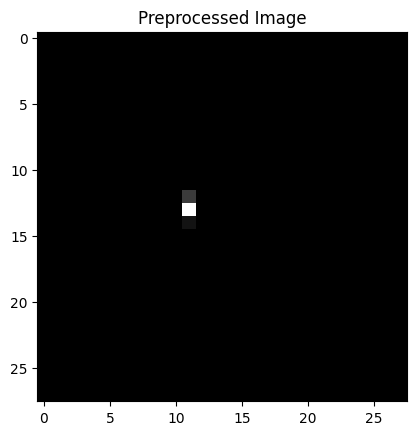

In [93]:
def predict_digit_DNN(image_path, model):
    """
    Predict the digit in a given image using LeNet-5.
    - image_path: Path to the image file.
    - model: Trained PyTorch model.
    Returns:
    - Predicted digit.
    """
    # Read the image
    image = cv2.imread(image_path)

    # Preprocess the image
    preprocessed_img = preprocess_image_DNN(image)

    # Run prediction
    with torch.no_grad():
        output = model(preprocessed_img)
        predicted_digit = torch.argmax(output, 1).item()
    return predicted_digit

import matplotlib.pyplot as plt

image_path = 'Output_Result/4/Col1__10.jpg'
image = cv2.imread(image_path)
preprocessed_img = preprocess_image_DNN(image)

plt.imshow(preprocessed_img.squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()


In [94]:
predicted_digit = predict_digit_DNN(image_path, model)
print("Predicted Digit:", predicted_digit)

Predicted Digit: 5


---

## Excel sheet generation

---

In [69]:
def open_excel(ids,data_col1,data_col2,data_col3,j):
    workbook = openpyxl.Workbook()
    sheet = workbook.active

    # Set headers for columns
    sheet['A1'] = 'ID'
    sheet['B1'] = 'Col1'
    sheet['C1'] = 'Col2'
    sheet['D1'] = 'Col3'

    # Fill the columns with corresponding data and set specific cells to have a red background color
    for i, id_value in enumerate(ids, start=2):  # Start from row 2 (as 1st row contains headers)
        sheet.cell(row=i, column=1, value=id_value)  # Fill IDs in column A
        
        sheet.cell(row=i, column=2, value=data_col1[i - 2])
    
        
        
        if data_col2[i-2] == 'question':  
            red_fill = PatternFill(start_color='FF0000', end_color='FF0000', fill_type='solid')
            sheet.cell(row=i, column=3).fill = red_fill  # Set column 3 cell to red
        elif data_col2[i-2] != 'empty':
            sheet.cell(row=i, column=3, value=data_col2[i - 2])
        elif data_col2[i-2] == 'empty':
             sheet.cell(row=i, column=3, value=0)
        if   data_col3[i-2] == 'question':  
            red_fill = PatternFill(start_color='FF0000', end_color='FF0000', fill_type='solid')
            sheet.cell(row=i, column=4).fill = red_fill  
        elif data_col3[i-2] != 'empty':
            sheet.cell(row=i, column=4, value=data_col3[i - 2])
        elif data_col2[i-2] == 'empty':
             sheet.cell(row=i, column=4, value=0)

    # Save the workbook
    workbook.save(f'Gradesheet{j}.xlsx')

In [ ]:
def data_samples_collection(directory_path, algorithm):
    # Choose the algorithm based on the provided input
    check = 'SVM' if algorithm == 0 else 'OCR' if algorithm == 1 else 'SVM'
    
    folders = os.listdir(directory_path)
    
    for folder in folders:
        folder_path = os.path.join(directory_path, folder + '/')
        print(f"Processing folder: {folder_path}")
        
        # Assuming each folder has these categories of images:
        gradesheet_data = load_images_for_prediction(directory_path)
        

        #################################################################

    # Predict for each gradesheet
    for gradesheet, grouped_images in gradesheet_data.items():
        print(f"Processing gradesheet: {gradesheet}")
        
        # Predict IDs
        id_images = grouped_images["Student_ID"]
        id_predictions = predict_student_ids(id_images, method="OCR")
        
        # Predict column 1 answers
        col1_images = grouped_images["Col1"]
        col1_predictions = predict_column1_answers(col1_images, method="SVM")
        
        # Predict column 2 scores
        col2_images = grouped_images["Col2"]
        col2_predictions = predict_column2_3_scores(col2_images)
        
        # Predict column 3 scores
        col3_images = grouped_images["Col3"]
        col3_predictions = predict_column2_3_scores(col3_images)
        ############################################################################

        # Clean up predictions (strip any unwanted characters)
        for i in range(len(id_predictions)):
            id_predictions[i] = id_predictions[i].strip()
            col1_predictions[i] = col1_predictions[i].strip()
        
        # Print the results
        print(f"Predicted Codes: {id_predictions}")
        print(f"Predicted Column 1 Answers: {col1_predictions}")
        print(f"Predicted Column 2 Scores: {col2_predictions}")
        print(f"Predicted Column 3 Scores: {col3_predictions}")
        
        # Assuming open_excel is a function that saves the predictions into an Excel file
        open_excel(id_predictions, col1_predictions, col2_predictions, col3_predictions, int(gradesheet))

# Example of calling the function
# The other input here is 1 or 0, choosing either SVM or OCR (1 : OCR)
data_samples_collection('Output_Result/', 1)  

Processing folder: Output_Result/1/
Processing folder: Output_Result/10/
Processing folder: Output_Result/11/
Processing folder: Output_Result/12/
Processing folder: Output_Result/13/
Processing folder: Output_Result/14/
Processing folder: Output_Result/15/
Processing folder: Output_Result/2/
Processing folder: Output_Result/3/
Processing folder: Output_Result/4/
Processing folder: Output_Result/5/
Processing folder: Output_Result/6/
Processing folder: Output_Result/7/
Processing folder: Output_Result/8/
Processing folder: Output_Result/9/
Processing gradesheet: 1
Predicted Codes: ['1180236', '2200022', '1180552', '1180207', '1180045', '1180212', '1180155', '1170343', '1180172', '1180333', '1180128', '1180255', '1180274', '1180056', '1180041', '1180606', '1180456']
Predicted Column 1 Answers: ['1', '0', '0', '9', '1', '2', '3', '4', '5', '2', '3', '4', '5', '6', '7', '2', '9']
Predicted Column 2 Scores: [2, 4, 2, 'question', 'question', 0, 0, 2, 'question', 0, 'question', 0, 3, 1, 5, 5